In [ ]:
import re
import pandas as pd
from datasets import load_dataset
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import  accuracy_score, precision_score, recall_score, f1_score
from gensim.models.fasttext import load_facebook_vectors
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np
from gensim.models import KeyedVectors
import seaborn as sns
from sklearn.metrics import pairwise_distances
from sklearn.metrics import silhouette_score, silhouette_samples, normalized_mutual_info_score
from sklearn.preprocessing import MultiLabelBinarizer
from collections import Counter
from unsloth import FastLanguageModel
from transformers import AutoTokenizer
import torch

In [ ]:
#Cleaning the text
def clean_text(text):
    text = text.lower()
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    return text.strip()

with open("stopwords-el.txt", encoding='utf-8') as f:
    stopwords_el = [clean_text(line) for line in f if line.strip()]

In [ ]:
dataset = load_dataset("DominusTea/GreekLegalSum", split="train")
df = pd.DataFrame(dataset)[['text', 'summary', 'case_category','case_tags']].dropna()
df['text_clean'] = df['text'].apply(clean_text)
df.head()


text  \
0  ŒëŒ°ŒôŒòŒúŒüŒ£ 970/2009 \n\nŒ§Œü ŒîŒôŒöŒëŒ£Œ§ŒóŒ°ŒôŒü Œ§ŒüŒ• ŒëŒ°ŒïŒôŒüŒ• ...   
1  ŒëœÅŒπŒ∏ŒºœåœÇ 1692/2009 \n\nŒ§Œü ŒîŒôŒöŒëŒ£Œ§ŒóŒ°ŒôŒü Œ§ŒüŒ• ŒëŒ°ŒïŒôŒüŒ•...   
2  ŒëœÅŒπŒ∏ŒºœåœÇ 92/2013 \n\nŒ§Œü ŒîŒôŒöŒëŒ£Œ§ŒóŒ°ŒôŒü Œ§ŒüŒ• ŒëŒ°ŒïŒôŒüŒ• Œ†...   
3  ŒëœÅŒπŒ∏ŒºœåœÇ 1502/2018 \n\nŒ§Œü ŒîŒôŒöŒëŒ£Œ§ŒóŒ°ŒôŒü Œ§ŒüŒ• ŒëŒ°ŒïŒôŒüŒ•...   
4  ŒëœÅŒπŒ∏ŒºœåœÇ 1501/2018 \n\nŒ§Œü ŒîŒôŒöŒëŒ£Œ§ŒóŒ°ŒôŒü Œ§ŒüŒ• ŒëŒ°ŒïŒôŒüŒ•...   

                                             summary      case_category  \
0  ŒëŒØœÑŒ∑œÉŒ∑ Œ±ŒΩŒ±ŒØœÅŒµœÉŒ∑œÇ Œ∫Œ±œÑŒ±Œ¥ŒπŒ∫Œ±œÉœÑŒπŒ∫ŒÆœÇ Œ±œÄŒøœÜŒ¨œÉŒµœâœÇ Œ≥ŒπŒ± ...  ŒëŒ∫œÖœÅœåœÑŒ∑œÑŒ± Œ±œÄœåŒªœÖœÑŒ∑   
1  ŒöŒ±Œ∏ŒøœÅŒπœÉŒºœåœÇ œÉœÖŒΩŒøŒªŒπŒ∫ŒÆœÇ œÄŒøŒπŒΩŒÆœÇ (Œ¨œÅŒ∏œÅŒø 551 ŒöŒ†Œî) ŒºŒµ...     Œ†ŒøŒπŒΩŒÆ œÉœÖŒΩŒøŒªŒπŒ∫ŒÆ   
2  ŒöŒ±œÑŒ±Œ¥ŒπŒ∫Œ±œÉœÑŒπŒ∫ŒÆ Œ±œÄœåœÜŒ±œÉŒ∑ Œ≥ŒπŒ± ŒºŒ∑ Œ∫Œ±œÑŒ±Œ≤ŒøŒªŒÆ œáœÅŒµœéŒΩ œÄœÅ...  ŒëŒ∫œÖœÅœåœÑŒ∑œÑŒ± Œ±œÄœåŒªœÖœÑŒ∑   
3  ŒëŒΩŒ±ŒØœÅŒµœÉŒ∑ ŒïŒπœÉŒ±Œ≥Œ≥ŒµŒªŒ≠Œ± ŒëœÅŒµŒØŒøœÖ Œ†Œ¨Œ≥ŒøœÖ Œ∫Œ±œÑŒ¨ Œ±Œ∏œâœâœÑŒπŒ∫ŒÆ...     ŒëŒ≤Œ¨œÉŒπŒºŒøŒπ ŒªœåŒ≥ŒøŒπ   
4  ŒöŒ±œÑ' ŒµŒæŒ±Œ∫ŒøŒªŒøœçŒ∏Œ∑œÉŒ∑ Œ±œÄŒ¨œÑŒ∑ Œ∫Œ±œÑ' ŒµœÄŒ¨Œ≥Œ≥ŒµŒªŒºŒ± Œ∫Œ±Œπ Œ∫Œ±œÑ...     ŒëŒ≤Œ¨œÉŒπŒºŒøŒπ ŒªœåŒ≥ŒøŒπ   

                                           case_tags  \
0  ŒëŒπœÑŒπŒøŒªŒøŒ≥ŒØŒ±œÇ ŒµœÄŒ¨œÅŒ∫ŒµŒπŒ±, ŒëŒ∫œÖœÅœåœÑŒ∑œÑŒ± Œ±œÄœåŒªœÖœÑŒ∑, ŒëœÄŒ¨œÑŒ∑...   
1  Œ†ŒøŒπŒΩŒÆ œÉœÖŒΩŒøŒªŒπŒ∫ŒÆ, ŒùœåŒºŒøœÖ ŒµœÜŒ±œÅŒºŒøŒ≥ŒÆ Œ∫Œ±Œπ ŒµœÅŒºŒ∑ŒΩŒµŒØŒ±, Œï...   
2  ŒëŒ∫œÖœÅœåœÑŒ∑œÑŒ± Œ±œÄœåŒªœÖœÑŒ∑, ŒëŒøœÅŒπœÉœÑŒØŒ± ŒªœåŒ≥ŒøœÖ Œ±ŒΩŒ±ŒπœÅŒ≠œÉŒµœâœÇ, ...   
3  ŒëŒΩŒ±ŒπœÅŒ≠œÉŒµœâœÇ Œ±œÄœåœÅœÅŒπœàŒ∑, ŒïŒπœÉŒ±Œ≥Œ≥ŒµŒªŒ≠Œ±œÇ ŒëœÅŒµŒØŒøœÖ Œ†Œ¨Œ≥ŒøœÖ,...   
4  ŒëŒ∫œÖœÅœåœÑŒ∑œÑŒ± Œ±œÄœåŒªœÖœÑŒ∑, ŒëŒΩŒ±ŒπœÅŒ≠œÉŒµœâœÇ Œ±œÄœåœÅœÅŒπœàŒ∑, ŒëœÄŒ¨œÑŒ∑,...   

                                          text_clean  
0  Œ±œÅŒπŒ∏ŒºŒøœÇ  \n\nœÑŒø Œ¥ŒπŒ∫Œ±œÉœÑŒ∑œÅŒπŒø œÑŒøœÖ Œ±œÅŒµŒπŒøœÖ œÄŒ±Œ≥ŒøœÖ\n ...  
1  Œ±œÅŒπŒ∏ŒºœåœÇ  \n\nœÑŒø Œ¥ŒπŒ∫Œ±œÉœÑŒ∑œÅŒπŒø œÑŒøœÖ Œ±œÅŒµŒπŒøœÖ œÄŒ±Œ≥ŒøœÖ\n ...  
2  Œ±œÅŒπŒ∏ŒºœåœÇ  \n\nœÑŒø Œ¥ŒπŒ∫Œ±œÉœÑŒ∑œÅŒπŒø œÑŒøœÖ Œ±œÅŒµŒπŒøœÖ œÄŒ±Œ≥ŒøœÖ\n\...  
3  Œ±œÅŒπŒ∏ŒºœåœÇ  \n\nœÑŒø Œ¥ŒπŒ∫Œ±œÉœÑŒ∑œÅŒπŒø œÑŒøœÖ Œ±œÅŒµŒπŒøœÖ œÄŒ±Œ≥ŒøœÖ\n\...  
4  Œ±œÅŒπŒ∏ŒºœåœÇ  \n\nœÑŒø Œ¥ŒπŒ∫Œ±œÉœÑŒ∑œÅŒπŒø œÑŒøœÖ Œ±œÅŒµŒπŒøœÖ œÄŒ±Œ≥ŒøœÖ\n\...

# B2.i


## Exploratory Data Analysis for **case_tags**

6298


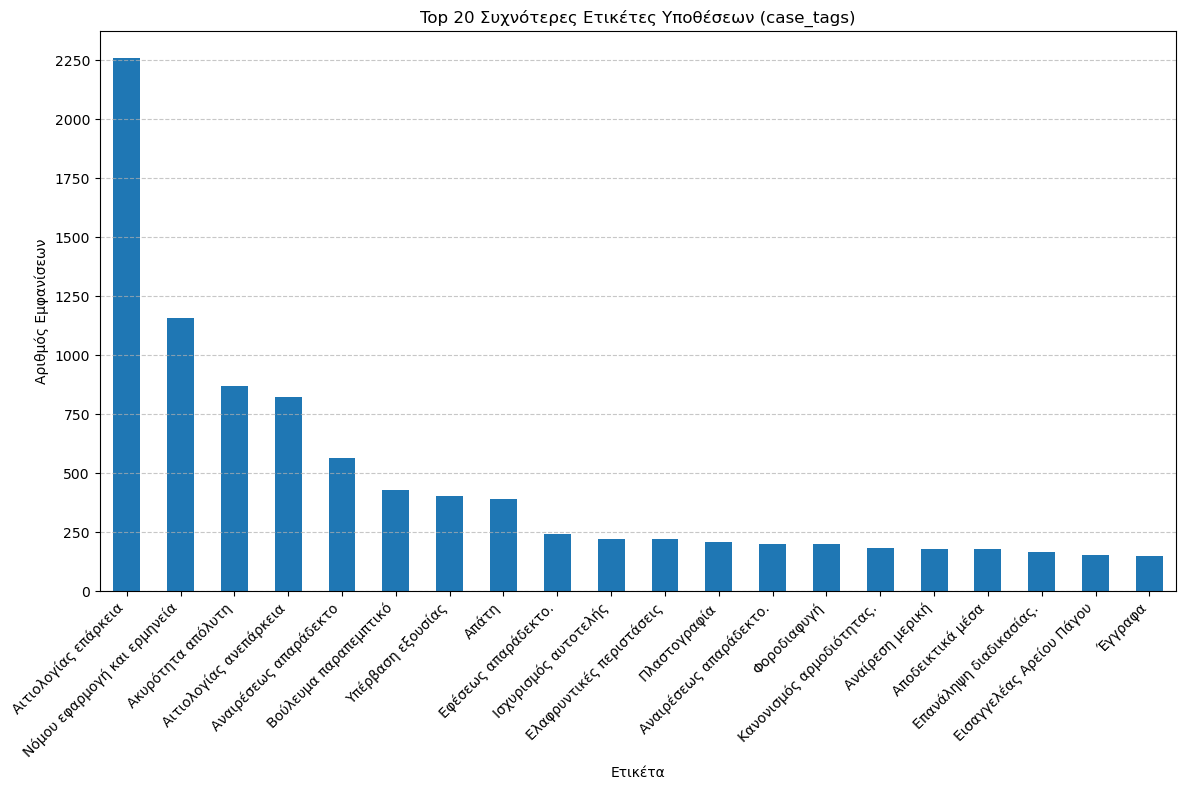

In [ ]:
case_tags_split = df['case_tags'].explode().dropna().astype(str).str.split(',')
print(len(case_tags_split))
case_tags_exploded = case_tags_split.explode().str.strip()
case_tags_counts = case_tags_exploded.value_counts()

plt.figure(figsize=(12, 8))
case_tags_counts.head(20).plot(kind='bar')
plt.title("Top 20 Œ£œÖœáŒΩœåœÑŒµœÅŒµœÇ ŒïœÑŒπŒ∫Œ≠œÑŒµœÇ Œ•œÄŒøŒ∏Œ≠œÉŒµœâŒΩ (case_tags)")
plt.ylabel("ŒëœÅŒπŒ∏ŒºœåœÇ ŒïŒºœÜŒ±ŒΩŒØœÉŒµœâŒΩ")
plt.xlabel("ŒïœÑŒπŒ∫Œ≠œÑŒ±")
plt.xticks(rotation=45, ha='right')
plt.yticks(np.arange(0, case_tags_counts.head(50).max() + 50, 250))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


**Œ£œÖŒºœÄŒ≠œÅŒ±œÉŒºŒ±:** Œó ŒµœÑŒπŒ∫Œ≠œÑŒ± "ŒëŒπœÑŒπŒøŒªŒøŒ≥ŒØŒ±œÇ ŒµœÄŒ¨œÅŒ∫ŒµŒπŒ±" Œ∫œÖœÅŒπŒ±œÅœáŒµŒØ ŒºŒµ ŒºŒµŒ≥Œ¨ŒªŒ∑ Œ¥ŒπŒ±œÜŒøœÅŒ¨, œÄŒ¨ŒΩœâ Œ±œÄœå 2.250 ŒµŒºœÜŒ±ŒΩŒØœÉŒµŒπœÇ. ŒëœÖœÑœå œÖœÄŒøŒ¥Œ∑ŒªœéŒΩŒµŒπ œåœÑŒπ Œ≠ŒΩŒ± ŒºŒµŒ≥Œ¨ŒªŒø œÄŒøœÉŒøœÉœÑœå œÑœâŒΩ Œ±œÄŒøœÜŒ¨œÉŒµœâŒΩ Œ±œÜŒøœÅŒ¨ ŒµŒªŒ≠Œ≥œáŒøœÖœÇ œÉœáŒµœÑŒπŒ∫Œ¨ ŒºŒµ œÑŒ∑ŒΩ œÄŒªŒ∑œÅœåœÑŒ∑œÑŒ± œÑŒ∑œÇ Œ±ŒπœÑŒπŒøŒªœåŒ≥Œ∑œÉŒ∑œÇ. ŒïŒΩœé Œ±Œ∫ŒøŒªŒøœÖŒ∏ŒøœçŒΩ ŒøŒπ ŒµœÑŒπŒ∫Œ≠œÑŒµœÇ "ŒùœåŒºŒøœÖ ŒµœÜŒ±œÅŒºŒøŒ≥ŒÆ Œ∫Œ±Œπ ŒµœÅŒºŒ∑ŒΩŒµŒØŒ±" Œ∫Œ±Œπ "ŒëŒ∫œÖœÅœåœÑŒ∑œÑŒ± Œ±œÄœåŒªœÖœÑŒ∑". Œ§Œ≠ŒªŒøœÇ Œ±œÄœåœÑŒøŒºŒ∑ œÄœÑœéœÉŒ∑ ŒºŒµœÑŒ¨ œÑŒ∑ŒΩ 5Œ∑-6Œ∑ ŒµœÑŒπŒ∫Œ≠œÑŒ± œåœÄŒøœÖ ŒªŒØŒ≥ŒµœÇ ŒµœÑŒπŒ∫Œ≠œÑŒµœÇ œÉœÖŒ≥Œ∫ŒµŒΩœÑœÅœéŒΩŒøœÖŒΩ œÑŒø ŒºŒµŒ≥Œ±ŒªœçœÑŒµœÅŒø ŒºŒ≠œÅŒøœÇ œÑœâŒΩ œÄŒµœÅŒπœÄœÑœéœÉŒµœâŒΩ.

Œ•œÄŒøŒªŒøŒ≥ŒπœÉŒºœåœÇ œÄŒªŒÆŒ∏ŒøœÖœÇ ŒµœÑŒπŒ∫ŒµœÑœéŒΩ Œ±ŒΩŒ¨ Œ±œÄœåœÜŒ±œÉŒ∑...


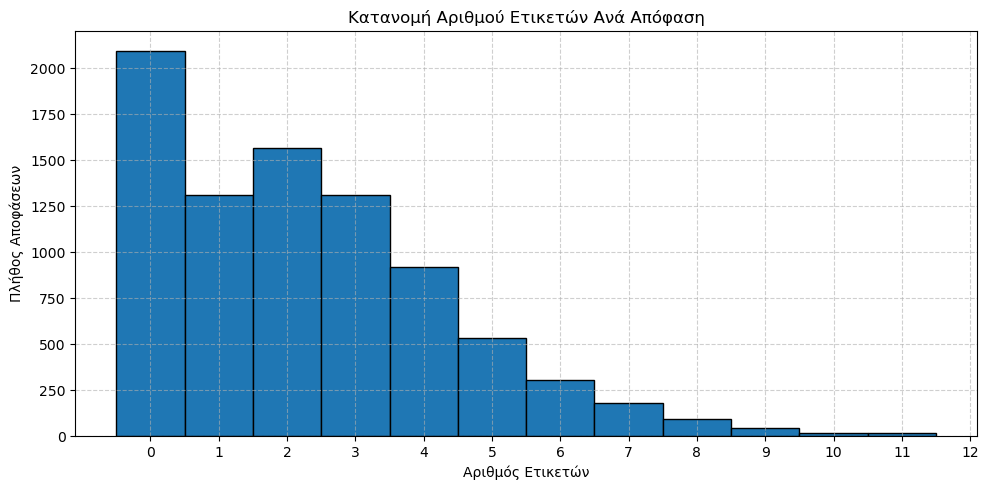

In [ ]:
print("Œ•œÄŒøŒªŒøŒ≥ŒπœÉŒºœåœÇ œÄŒªŒÆŒ∏ŒøœÖœÇ ŒµœÑŒπŒ∫ŒµœÑœéŒΩ Œ±ŒΩŒ¨ Œ±œÄœåœÜŒ±œÉŒ∑...")
df['num_tags'] = df['case_tags'].apply(lambda x: len(str(x).split(',')) if pd.notnull(x) else 0)
plt.figure(figsize=(10, 5))
plt.hist(df['num_tags'], bins=range(0, 13), edgecolor='black', align='left')
plt.title("ŒöŒ±œÑŒ±ŒΩŒøŒºŒÆ ŒëœÅŒπŒ∏ŒºŒøœç ŒïœÑŒπŒ∫ŒµœÑœéŒΩ ŒëŒΩŒ¨ ŒëœÄœåœÜŒ±œÉŒ∑")
plt.xlabel("ŒëœÅŒπŒ∏ŒºœåœÇ ŒïœÑŒπŒ∫ŒµœÑœéŒΩ")
plt.ylabel("Œ†ŒªŒÆŒ∏ŒøœÇ ŒëœÄŒøœÜŒ¨œÉŒµœâŒΩ")
plt.xticks(np.arange(0, 13, 1))
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


In [ ]:
# Œ•œÄŒøŒªŒøŒ≥ŒπœÉŒºœåœÇ œÄŒªŒÆŒ∏ŒøœÖœÇ Œ±œÄŒøœÜŒ¨œÉŒµœâŒΩ ŒºŒµ Œ∫ŒµŒΩœå ŒÆ null case_tags
empty_tags_count = df['case_tags'].isna().sum()
print(f"ŒëœÅŒπŒ∏ŒºœåœÇ Œ±œÄŒøœÜŒ¨œÉŒµœâŒΩ ŒºŒµ Œ∫ŒµŒΩœå case_tags: {empty_tags_count}")


ŒëœÅŒπŒ∏ŒºœåœÇ Œ±œÄŒøœÜŒ¨œÉŒµœâŒΩ ŒºŒµ Œ∫ŒµŒΩœå case_tags: 2097


**Œ£œÖŒºœÄŒ≠œÅŒ±œÉŒºŒ±:** ŒúŒµŒ≥Œ¨ŒªŒø œÄŒøœÉŒøœÉœÑœå Œ±œÄŒøœÜŒ¨œÉŒµœâŒΩ (2.097) Œ¥ŒµŒΩ œÜŒ≠œÅŒµŒπ Œ∫Œ±Œ∏œåŒªŒøœÖ ŒµœÑŒπŒ∫Œ≠œÑŒµœÇ (0 tags), Œ±œÖœÑœå ŒºœÄŒøœÅŒµŒØ ŒΩŒ± ŒøœÜŒµŒØŒªŒµœÑŒ±Œπ œÉŒµ Œ±œÄŒøœÜŒ¨œÉŒµŒπœÇ œÄŒøœÖ Œ¥ŒµŒΩ ŒµŒºœÄŒØœÄœÑŒøœÖŒΩ œÉŒµ Œ∫Œ¨œÄŒøŒπŒ± œÄœÅŒøŒ∫Œ±Œ∏ŒøœÅŒπœÉŒºŒ≠ŒΩŒ∑ Œ∏ŒµŒºŒ±œÑŒπŒ∫ŒÆ. ŒïŒΩœé Œ∑ œÄŒªŒµŒπŒøŒΩœåœÑŒ∑œÑŒ± œÑœâŒΩ Œ±œÄŒøœÜŒ¨œÉŒµœâŒΩ Œ≠œáŒµŒπ 1 Œ≠œâœÇ 3 ŒµœÑŒπŒ∫Œ≠œÑŒµœÇ, œÄŒøœÖ œÖœÄŒøŒ¥Œ∑ŒªœéŒΩŒµŒπ Œ∏ŒµŒºŒ±œÑŒπŒ∫ŒÆ ŒµœÉœÑŒØŒ±œÉŒ∑ (Œ∫Œ¨Œ∏Œµ Œ±œÄœåœÜŒ±œÉŒ∑ Œ±œÜŒøœÅŒ¨ œÉœÖŒΩŒÆŒ∏œâœÇ ŒªŒØŒ≥Œ± ŒΩŒøŒºŒπŒ∫Œ¨ Œ∂Œ∑œÑŒÆŒºŒ±œÑŒ±). Œ§Œ≠ŒªŒøœÇ œÖœÄŒ¨œÅœáŒøœÖŒΩ Œ±œÄŒøœÜŒ¨œÉŒµŒπœÇ ŒºŒµ 6+ ŒµœÑŒπŒ∫Œ≠œÑŒµœÇ ŒøŒπ ŒøœÄŒøŒπŒµœÇ ŒµŒπŒΩŒ±Œπ œÉœáŒµœÑŒπŒ∫Œ¨ ŒªŒØŒ≥ŒµœÇ, Œ∑ Œ∫Œ±œÑŒ±ŒΩŒøŒºŒÆ œÄŒ≠œÜœÑŒµŒπ Œ±œÄœåœÑŒøŒºŒ± ŒºŒµœÑŒ¨ œÑŒø 4, Œ±œÖœÑŒ≠œÇ ŒØœÉœâœÇ ŒΩŒ± œÄŒµœÅŒπŒªŒ±ŒºŒ≤Œ¨ŒΩŒøœÖŒΩ œÄŒπŒø œÄŒøŒªœçœÄŒªŒøŒ∫Œ±, œÄŒøŒªœÖŒ∏ŒµŒºŒ±œÑŒπŒ∫Œ¨ ŒÆ ŒºŒπŒ∫œÑŒ¨ ŒΩŒøŒºŒπŒ∫Œ¨ Œ∂Œ∑œÑŒÆŒºŒ±œÑŒ±.

Œ•œÄŒøŒªŒøŒ≥ŒπœÉŒºœåœÇ œÉœÖŒΩ-ŒµŒºœÜŒ±ŒΩŒπŒ∂œåŒºŒµŒΩœâŒΩ ŒµœÑŒπŒ∫ŒµœÑœéŒΩ ŒºŒµ Œ∫Œ±ŒΩŒøŒΩŒπŒ∫ŒøœÄŒøŒØŒ∑œÉŒ∑...


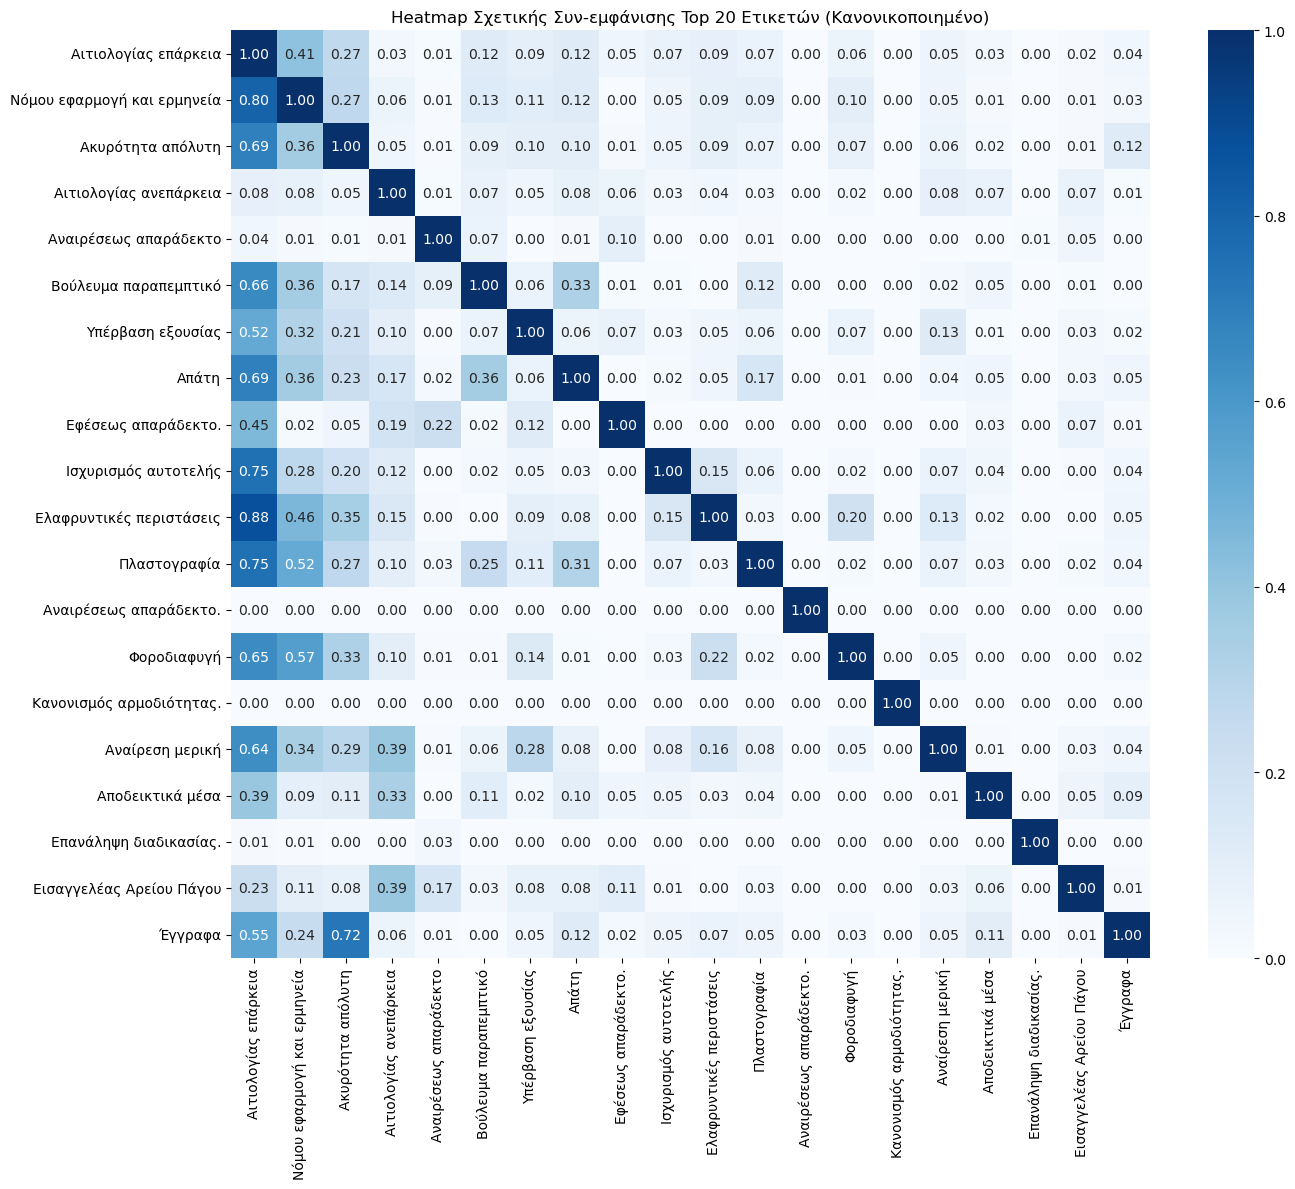

In [ ]:
print("Œ•œÄŒøŒªŒøŒ≥ŒπœÉŒºœåœÇ œÉœÖŒΩ-ŒµŒºœÜŒ±ŒΩŒπŒ∂œåŒºŒµŒΩœâŒΩ ŒµœÑŒπŒ∫ŒµœÑœéŒΩ ŒºŒµ Œ∫Œ±ŒΩŒøŒΩŒπŒ∫ŒøœÄŒøŒØŒ∑œÉŒ∑...")
df['clean_tags'] = df['case_tags'].dropna().apply(lambda x: [tag.strip() for tag in str(x).split(',')])
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()
tags_encoded = mlb.fit_transform(df['clean_tags'].dropna())
tags_df = pd.DataFrame(tags_encoded, columns=mlb.classes_)

# ŒïœÄŒπŒªŒøŒ≥ŒÆ Top 30 œÄŒπŒø œÉœÖœáŒΩœéŒΩ ŒµœÑŒπŒ∫ŒµœÑœéŒΩ Œ≥ŒπŒ± ŒµœÖŒ±ŒΩŒ¨Œ≥ŒΩœâœÉœÑŒø heatmap
top_tags = case_tags_counts.head(20).index.tolist()
co_occurrence = tags_df[top_tags].T.dot(tags_df[top_tags])
co_occurrence_pct = co_occurrence.div(co_occurrence.max(axis=1), axis=0)

plt.figure(figsize=(14, 12))
sns.heatmap(co_occurrence_pct, cmap="Blues", annot=True, fmt=".2f")
plt.title("Heatmap Œ£œáŒµœÑŒπŒ∫ŒÆœÇ Œ£œÖŒΩ-ŒµŒºœÜŒ¨ŒΩŒπœÉŒ∑œÇ Top 20 ŒïœÑŒπŒ∫ŒµœÑœéŒΩ (ŒöŒ±ŒΩŒøŒΩŒπŒ∫ŒøœÄŒøŒπŒ∑ŒºŒ≠ŒΩŒø)")
plt.tight_layout()
plt.show()


**Œ£œÖŒºœÄŒ≠œÅŒ±œÉŒºŒ±:** Œ§Œø heatmap Œ¥ŒµŒØœáŒΩŒµŒπ œåœÑŒπ Œ∑ "ŒëŒπœÑŒπŒøŒªŒøŒ≥ŒØŒ±œÇ ŒµœÄŒ¨œÅŒ∫ŒµŒπŒ±" œÉœÖœÉœáŒµœÑŒØŒ∂ŒµœÑŒ±Œπ Œ≠ŒΩœÑŒøŒΩŒ± ŒºŒµ œÉœáŒµŒ¥œåŒΩ œåŒªŒµœÇ œÑŒπœÇ ŒµœÄœåŒºŒµŒΩŒµœÇ œÄŒπŒø œÉœÖœáŒΩŒ≠œÇ ŒµœÑŒπŒ∫Œ≠œÑŒµœÇ(Œ¥ŒπŒ±Œ≥œÅŒ±ŒºŒºŒ± 1), œåœÄœâœÇ Œ∑ "ŒùœåŒºŒøœÖ ŒµœÜŒ±œÅŒºŒøŒ≥ŒÆ Œ∫Œ±Œπ ŒµœÅŒºŒ∑ŒΩŒµŒØŒ±" (0.80), Œ∑ "ŒëŒ∫œÖœÅœåœÑŒ∑œÑŒ± Œ±œÄœåŒªœÖœÑŒ∑" (0.69) Œ∫Œ±Œπ Œ∑ "ŒëŒπœÑŒπŒøŒªŒøŒ≥ŒØŒ±œÇ Œ±ŒΩŒµœÄŒ¨œÅŒ∫ŒµŒπŒ±" (0.63). Œó œÉœÖŒºœÄŒµœÅŒπœÜŒøœÅŒ¨ Œ±œÖœÑŒÆ ŒµŒØŒΩŒ±Œπ Œ±œÄœåŒªœÖœÑŒ± ŒªŒøŒ≥ŒπŒ∫ŒÆ Œ∫Œ±Œπ Œ±ŒΩŒ±ŒºŒµŒΩœåŒºŒµŒΩŒ∑, Œ∫Œ±Œ∏œéœÇ ŒøŒπ Œ±œÄŒøœÜŒ¨œÉŒµŒπœÇ œÄŒøœÖ ŒµŒªŒ≠Œ≥œáŒøœÖŒΩ œÑŒ∑ŒΩ ŒµœÄŒ¨œÅŒ∫ŒµŒπŒ± Œ±ŒπœÑŒπŒøŒªœåŒ≥Œ∑œÉŒ∑œÇ œÉœÖœáŒΩŒ¨ ŒµŒºœÄŒªŒ≠Œ∫ŒøœÖŒΩ Œ∫Œ±Œπ Œ¨ŒªŒªŒµœÇ ŒºŒøœÅœÜŒ≠œÇ ŒΩŒøŒºŒπŒ∫ŒÆœÇ œÄŒªŒ∑ŒºŒºŒ≠ŒªŒµŒπŒ±œÇ ŒÆ ŒµœÅŒºŒ∑ŒΩŒµœÖœÑŒπŒ∫ŒÆœÇ Œ±œÄœåŒ∫ŒªŒπœÉŒ∑œÇ. ŒöŒ±Œ∏œéœÇ Œ∫Œ±œÑŒµŒ≤Œ±ŒØŒΩŒøœÖŒºŒµ œÉŒµ ŒªŒπŒ≥œåœÑŒµœÅŒø œÉœÖœáŒΩŒ≠œÇ ŒµœÑŒπŒ∫Œ≠œÑŒµœÇ, œÄŒ±œÅŒ±œÑŒ∑œÅŒµŒØœÑŒ±Œπ Œ∫Œ±Œπ œÉœÑŒ±Œ¥ŒπŒ±Œ∫ŒÆ ŒºŒµŒØœâœÉŒ∑ œÑŒ∑œÇ œÉœÖœÉœáŒ≠œÑŒπœÉŒ∑œÇ.

Œ£œÖŒΩŒµœÄœéœÇ, œÑŒø heatmap ŒªŒµŒπœÑŒøœÖœÅŒ≥ŒµŒØ ŒµœÄŒπŒ≤ŒµŒ≤Œ±ŒπœâœÑŒπŒ∫Œ¨ Œ≥ŒπŒ± œÑŒø Œ≥œÅŒ¨œÜŒ∑ŒºŒ± œÉœÖœáŒΩŒøœÑŒÆœÑœâŒΩ, ŒµŒΩŒπœÉœáœçŒøŒΩœÑŒ±œÇ œÑŒ∑ŒΩ ŒπŒ¥Œ≠Œ± œåœÑŒπ œÖœÄŒ¨œÅœáŒµŒπ ŒºŒπŒ± œÄœÖŒ∫ŒΩŒÆ ¬´Œ¥ŒπŒ∫œÑœçœâœÉŒ∑¬ª Œ±ŒΩŒ¨ŒºŒµœÉŒ± œÉœÑŒπœÇ œÄŒπŒø Œ¥Œ∑ŒºŒøœÜŒπŒªŒµŒØœÇ Œ≠ŒΩŒΩŒøŒπŒµœÇ, Œ∑ ŒøœÄŒøŒØŒ± œåŒºœâœÇ ŒµŒæŒ±œÉŒ∏ŒµŒΩŒµŒØ œÉœÑŒ±Œ¥ŒπŒ±Œ∫Œ¨ œåœÉŒø Œ±œÄŒøŒºŒ±Œ∫œÅœÖŒΩœåŒºŒ±œÉœÑŒµ Œ±œÄœå œÑŒπœÇ œÉœÖœáŒΩœåœÑŒµœÅŒµœÇ ŒµœÑŒπŒ∫Œ≠œÑŒµœÇ.

## Exploratory Data Analysis for **case_category**

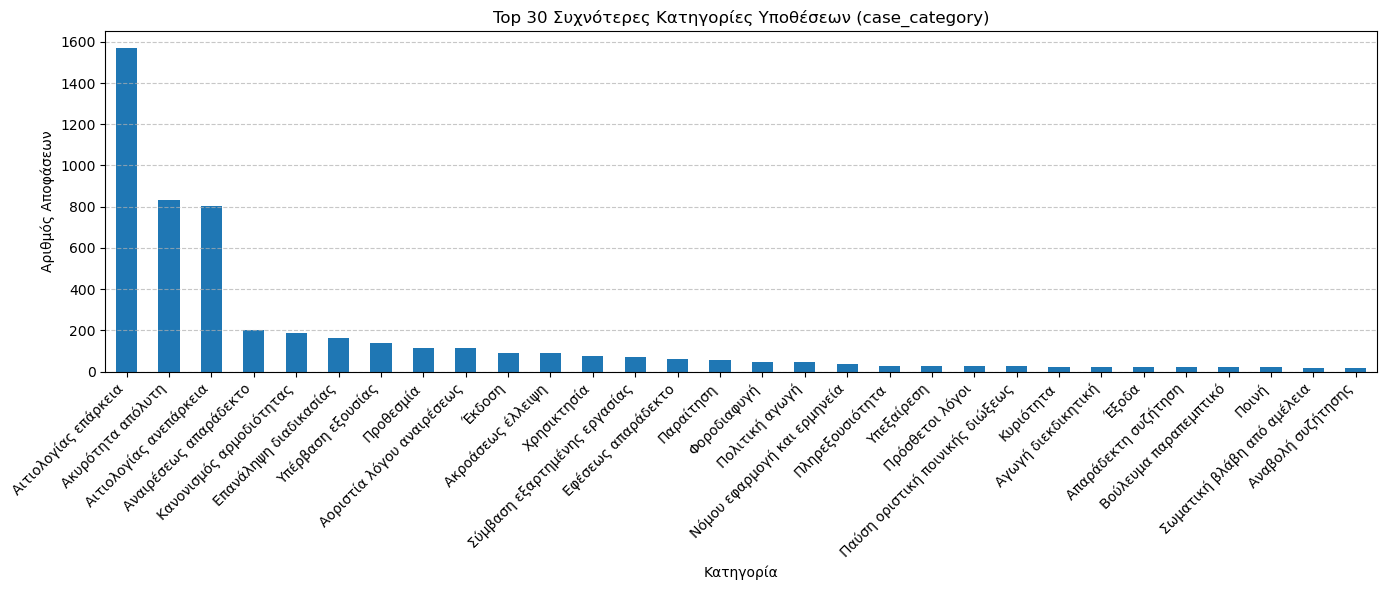

In [ ]:
case_category_counts = df['case_category'].value_counts()
plt.figure(figsize=(14, 6))
case_category_counts.head(30).plot(kind='bar')
plt.title("Top 30 Œ£œÖœáŒΩœåœÑŒµœÅŒµœÇ ŒöŒ±œÑŒ∑Œ≥ŒøœÅŒØŒµœÇ Œ•œÄŒøŒ∏Œ≠œÉŒµœâŒΩ (case_category)")
plt.ylabel("ŒëœÅŒπŒ∏ŒºœåœÇ ŒëœÄŒøœÜŒ¨œÉŒµœâŒΩ")
plt.xlabel("ŒöŒ±œÑŒ∑Œ≥ŒøœÅŒØŒ±")
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [ ]:
# ŒëŒΩŒ¨ŒªœÖœÉŒ∑ œÉœÖŒ≥Œ∫ŒµŒ∫œÅŒπŒºŒ≠ŒΩŒ∑œÇ Œ∫Œ±œÑŒ∑Œ≥ŒøœÅŒØŒ±œÇ
target_category = "ŒëŒΩŒ±Œ≤ŒøŒªŒÆ œÉœÖŒ∂ŒÆœÑŒ∑œÉŒ∑œÇ"  # ŒºœÄŒøœÅŒµŒØœÇ ŒΩŒ± Œ±ŒªŒªŒ¨ŒæŒµŒπœÇ œÑŒø œåŒΩŒøŒºŒ±
count = df[df['case_category'] == target_category].shape[0]
print(f"Œó Œ∫Œ±œÑŒ∑Œ≥ŒøœÅŒØŒ± '{target_category}' ŒµŒºœÜŒ±ŒΩŒØŒ∂ŒµœÑŒ±Œπ œÉŒµ {count} Œ±œÄŒøœÜŒ¨œÉŒµŒπœÇ.")


Œó Œ∫Œ±œÑŒ∑Œ≥ŒøœÅŒØŒ± 'ŒëŒΩŒ±Œ≤ŒøŒªŒÆ œÉœÖŒ∂ŒÆœÑŒ∑œÉŒ∑œÇ' ŒµŒºœÜŒ±ŒΩŒØŒ∂ŒµœÑŒ±Œπ œÉŒµ 20 Œ±œÄŒøœÜŒ¨œÉŒµŒπœÇ.


**Œ£œÖŒºœÄŒµœÅŒ¨œÉŒºŒ±œÑŒ±:** Œó Œ±ŒΩŒ¨ŒªœÖœÉŒ∑ œÑŒ∑œÇ œÉœÖœáŒΩœåœÑŒ∑œÑŒ±œÇ ŒµŒºœÜŒ¨ŒΩŒπœÉŒ∑œÇ œÑœâŒΩ Œ∫Œ±œÑŒ∑Œ≥ŒøœÅŒπœéŒΩ œÖœÄŒøŒ∏Œ≠œÉŒµœâŒΩ Œ±œÄŒøŒ∫Œ±ŒªœçœÄœÑŒµŒπ ŒºŒπŒ± ŒµŒæŒ±ŒπœÅŒµœÑŒπŒ∫Œ¨ Œ¨ŒΩŒπœÉŒ∑ Œ∫Œ±œÑŒ±ŒΩŒøŒºŒÆ. Œ£œÖŒ≥Œ∫ŒµŒ∫œÅŒπŒºŒ≠ŒΩŒ± ŒøŒπ œÑœÅŒµŒπœÇ œÄœÅœéœÑŒµœÇ Œ∫Œ±œÑŒ∑Œ≥ŒøœÅŒØŒµœÇ œÉœÖŒ≥Œ∫ŒµŒΩœÑœÅœéŒΩŒøœÖŒΩ œÖœÄŒµœÅœÄŒøŒªŒªŒ±œÄŒªŒ¨œÉŒπŒø Œ±œÅŒπŒ∏Œºœå Œ±œÄŒøœÜŒ¨œÉŒµœâŒΩ (ŒºŒµ œÑŒ∑ŒΩ œÄœÅœéœÑŒ∑ ŒΩŒ± ŒæŒµœÄŒµœÅŒΩŒ¨ œÑŒπœÇ 1.600). ŒëœÄœå œÑŒ∑ŒΩ 4Œ∑ Œ∏Œ≠œÉŒ∑ Œ∫Œ±Œπ Œ∫Œ¨œÑœâ, œÄŒ±œÅŒ±œÑŒ∑œÅŒµŒØœÑŒ±Œπ ŒºŒπŒ± Œ∫Œ±œÑŒ±Œ∫œåœÅœÖœÜŒ∑ œÄœÑœéœÉŒ∑, ŒµŒΩŒ¥ŒµŒπŒ∫œÑŒπŒ∫Œ¨, Œ∑ 30ŒÆ œÄŒπŒø œÉœÖœáŒΩŒÆ Œ∫Œ±œÑŒ∑Œ≥ŒøœÅŒØŒ±, "ŒëŒΩŒ±Œ≤ŒøŒªŒÆ œÉœÖŒ∂ŒÆœÑŒ∑œÉŒ∑œÇ", Œ∫Œ±œÑŒ±Œ≥œÅŒ¨œÜŒµŒπ ŒºœåŒªŒπœÇ 20 Œ±œÄŒøœÜŒ¨œÉŒµŒπœÇ

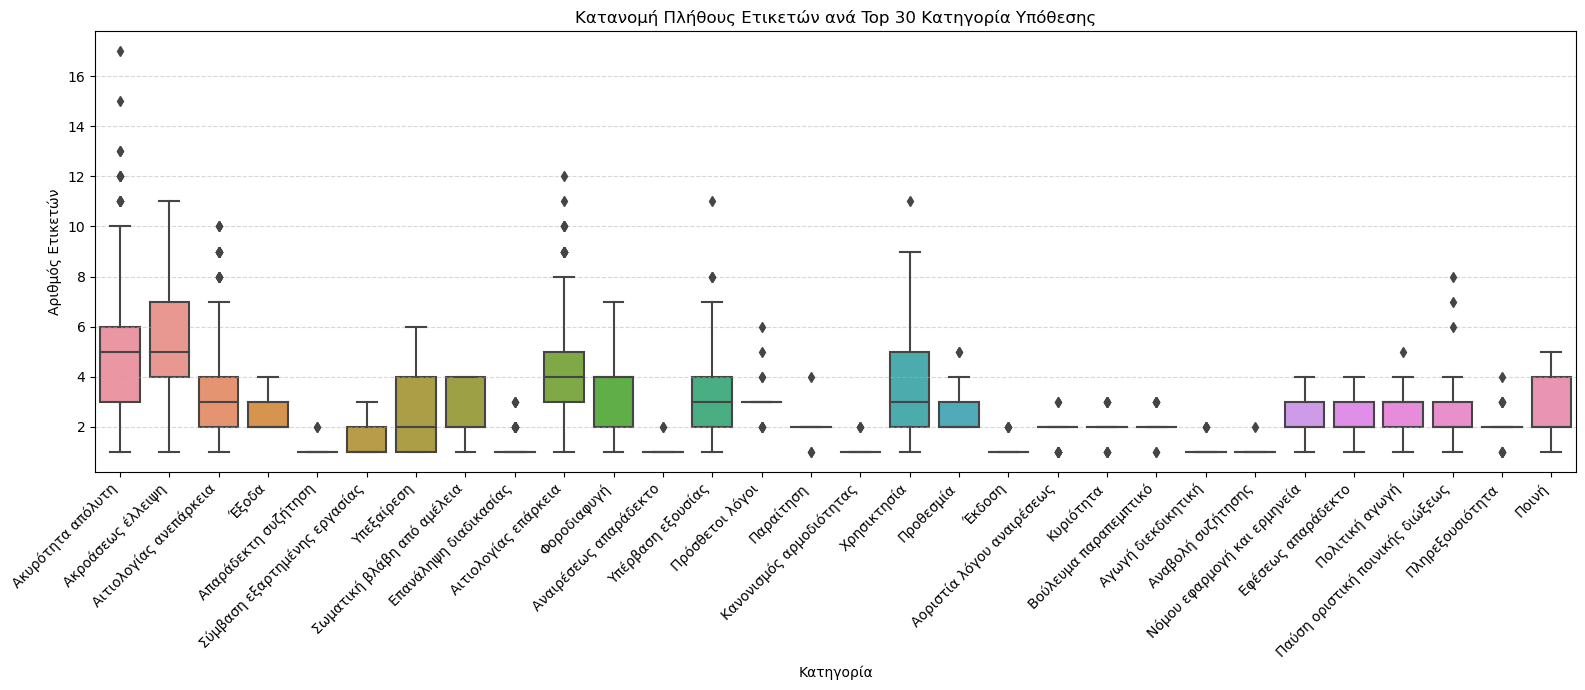

In [ ]:
top_30_categories = case_category_counts.head(30).index.tolist()
plt.figure(figsize=(16, 7))
sns.boxplot(data=df[df['case_category'].isin(top_30_categories) & (df['num_tags'] > 0)],
            x='case_category', y='num_tags')
plt.xticks(rotation=45, ha='right')
plt.title("ŒöŒ±œÑŒ±ŒΩŒøŒºŒÆ Œ†ŒªŒÆŒ∏ŒøœÖœÇ ŒïœÑŒπŒ∫ŒµœÑœéŒΩ Œ±ŒΩŒ¨ Top 30 ŒöŒ±œÑŒ∑Œ≥ŒøœÅŒØŒ± Œ•œÄœåŒ∏ŒµœÉŒ∑œÇ")
plt.ylabel("ŒëœÅŒπŒ∏ŒºœåœÇ ŒïœÑŒπŒ∫ŒµœÑœéŒΩ")
plt.xlabel("ŒöŒ±œÑŒ∑Œ≥ŒøœÅŒØŒ±")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


**Œ£œÖŒºœÄŒµœÅŒ¨œÉŒºŒ±œÑŒ±:** Œ§Œø œÉœÖŒ≥Œ∫ŒµŒ∫œÅŒπŒºŒ≠ŒΩŒø Œ≥œÅŒ¨œÜŒ∑ŒºŒ± Œ±ŒΩŒ±Œ¥ŒµŒπŒ∫ŒΩœçŒµŒπ œÑŒ∑ Œ∏ŒµŒºŒ±œÑŒπŒ∫ŒÆ œÄŒøŒªœÖœÄŒªŒøŒ∫œåœÑŒ∑œÑŒ± œÑœâŒΩ œÖœÄŒøŒ∏Œ≠œÉŒµœâŒΩ ŒºŒµ Œ≤Œ¨œÉŒ∑ œÑŒøŒΩ Œ±œÅŒπŒ∏Œºœå ŒµœÑŒπŒ∫ŒµœÑœéŒΩ (case_tags) œÄŒøœÖ œÉœÖŒΩŒøŒ¥ŒµœçŒøœÖŒΩ Œ∫Œ¨Œ∏Œµ Œ∫Œ±œÑŒ∑Œ≥ŒøœÅŒØŒ± Œ±œÄœåœÜŒ±œÉŒ∑œÇ. ŒüœÅŒπœÉŒºŒ≠ŒΩŒµœÇ Œ∫Œ±œÑŒ∑Œ≥ŒøœÅŒØŒµœÇ œÄŒ±œÅŒøœÖœÉŒπŒ¨Œ∂ŒøœÖŒΩ œÉŒ±œÜœéœÇ Œ±œÖŒæŒ∑ŒºŒ≠ŒΩŒø œÄŒªŒÆŒ∏ŒøœÇ ŒµœÑŒπŒ∫ŒµœÑœéŒΩ ,ŒøœÄœâœÇ  "ŒëŒ∫œÖœÅœåœÑŒ∑œÑŒ± Œ±œÄœåŒªœÖœÑŒ∑", "ŒëŒ∫œÅŒøŒ¨œÉŒµœâœÇ Œ≠ŒªŒªŒµŒπœàŒ∑" Œ∫Œ±Œπ "ŒëŒπœÑŒπŒøŒªŒøŒ≥ŒØŒ±œÇ Œ±ŒΩŒµœÄŒ¨œÅŒ∫ŒµŒπŒ±", Œ≠œáŒøœÖŒΩ œåœáŒπ ŒºœåŒΩŒø œÖœàŒ∑ŒªŒøœçœÇ ŒºŒ≠œÉŒøœÖœÇ œåœÅŒøœÖœÇ Œ±ŒªŒªŒ¨ Œ∫Œ±Œπ ŒµœÖœÅœç ŒµœçœÅŒøœÇ œÑŒπŒºœéŒΩ. ŒëœÖœÑœå œÖœÄŒøŒ¥Œ∑ŒªœéŒΩŒµŒπ œåœÑŒπ ŒøŒπ Œ±œÄŒøœÜŒ¨œÉŒµŒπœÇ œÉŒµ Œ±œÖœÑŒ≠œÇ œÑŒπœÇ Œ∫Œ±œÑŒ∑Œ≥ŒøœÅŒØŒµœÇ Œ±Œ≥Œ≥ŒØŒ∂ŒøœÖŒΩ œÄŒøŒªŒªŒ¨ Œ¥ŒπŒ±œÜŒøœÅŒµœÑŒπŒ∫Œ¨ ŒΩŒøŒºŒπŒ∫Œ¨ Œ∏Œ≠ŒºŒ±œÑŒ± œÑŒ±œÖœÑœåœáœÅŒøŒΩŒ±. ŒÜŒªŒªŒµœÇ Œ∫Œ±œÑŒ∑Œ≥ŒøœÅŒØŒµœÇ, œåœÄœâœÇ "ŒëœÄŒ±œÅŒ¨Œ¥ŒµŒ∫œÑŒ∑ œÉœÖŒ∂ŒÆœÑŒ∑œÉŒ∑" ŒÆ "ŒëŒΩŒ±Œ≤ŒøŒªŒÆ œÉœÖŒ∂ŒÆœÑŒ∑œÉŒ∑œÇ", ŒµŒºœÜŒ±ŒΩŒØŒ∂ŒøœÖŒΩ œÉœÑŒ±Œ∏ŒµœÅŒ¨ œáŒ±ŒºŒ∑Œªœå Œ±œÅŒπŒ∏Œºœå ŒµœÑŒπŒ∫ŒµœÑœéŒΩ, Œ±œÖœÑœå Œ¥ŒµŒØœáŒΩŒµŒπ œåœÑŒπ ŒµŒØŒΩŒ±Œπ Œ∏ŒµŒºŒ±œÑŒπŒ∫Œ¨ œÄŒµœÅŒπŒøœÅŒπœÉŒºŒ≠ŒΩŒµœÇ. Œ§Œ≠ŒªŒøœÇ, Œ∑ œÄŒ±œÅŒøœÖœÉŒØŒ± œÄŒøŒªŒªœéŒΩ ŒµŒæŒ±ŒπœÅŒ≠œÉŒµœâŒΩ (outliers) œÉŒµ ŒøœÅŒπœÉŒºŒ≠ŒΩŒµœÇ Œ∫Œ±œÑŒ∑Œ≥ŒøœÅŒØŒµœÇ (œÄ.œá. œÑŒπŒºŒ≠œÇ > 10 ŒµœÑŒπŒ∫Œ≠œÑŒµœÇ) ŒºŒ±œÅœÑœÖœÅŒ¨ œÑŒ∑ŒΩ œçœÄŒ±œÅŒæŒ∑ Œ±œÄŒøœÜŒ¨œÉŒµœâŒΩ ŒπŒ¥ŒπŒ±ŒØœÑŒµœÅŒ∑œÇ ŒΩŒøŒºŒπŒ∫ŒÆœÇ œÄŒøŒªœÖœÄŒªŒøŒ∫œåœÑŒ∑œÑŒ±œÇ.

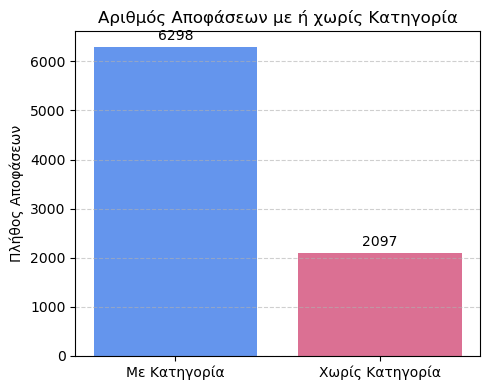

In [ ]:
missing_case_category = df['case_category'].isna().sum()
has_category = len(df) - missing_case_category
plt.figure(figsize=(5, 4))
bars = plt.bar(['ŒúŒµ ŒöŒ±œÑŒ∑Œ≥ŒøœÅŒØŒ±', 'ŒßœâœÅŒØœÇ ŒöŒ±œÑŒ∑Œ≥ŒøœÅŒØŒ±'], [has_category, missing_case_category], color=['cornflowerblue', 'palevioletred'])
plt.title("ŒëœÅŒπŒ∏ŒºœåœÇ ŒëœÄŒøœÜŒ¨œÉŒµœâŒΩ ŒºŒµ ŒÆ œáœâœÅŒØœÇ ŒöŒ±œÑŒ∑Œ≥ŒøœÅŒØŒ±")
plt.ylabel("Œ†ŒªŒÆŒ∏ŒøœÇ ŒëœÄŒøœÜŒ¨œÉŒµœâŒΩ")
plt.grid(axis='y', linestyle='--', alpha=0.6)

# Œ†œÅŒøœÉŒ∏ŒÆŒ∫Œ∑ œÑŒπŒºœéŒΩ œÄŒ¨ŒΩœâ Œ±œÄœå œÑŒπœÇ ŒºœÄŒ¨œÅŒµœÇ
for bar in bars:
    height = bar.get_height()
    plt.annotate(f'{int(height)}', xy=(bar.get_x() + bar.get_width() / 2, height),
                 xytext=(0, 3), textcoords="offset points", ha='center', va='bottom')

plt.tight_layout()
plt.show()


**Œ£œÖŒºœÄŒµœÅŒ¨œÉŒºŒ±œÑŒ±:** ŒëœÄœå œÑŒπœÇ 8.395 œÉœÖŒΩŒøŒªŒπŒ∫Œ≠œÇ Œ±œÄŒøœÜŒ¨œÉŒµŒπœÇ, ŒøŒπ 6.298 Œ≠œáŒøœÖŒΩ Œ¥ŒπŒ±Œ∏Œ≠œÉŒπŒºŒø œÄŒµŒ¥ŒØŒø case_category, ŒµŒΩœé ŒøŒπ 2.097 Œ¥ŒµŒΩ œÄŒµœÅŒπŒªŒ±ŒºŒ≤Œ¨ŒΩŒøœÖŒΩ Œ∫Œ±œÑŒ∑Œ≥ŒøœÅŒØŒ±, œÑŒø œÄŒøœÉŒøœÉœÑœå Œ±œÖœÑœå ŒµŒØŒΩŒ±Œπ Œ±ŒæŒπŒøœÉŒ∑ŒºŒµŒØœâœÑŒø.

ŒîŒ∑ŒºŒπŒøœÖœÅŒ≥ŒØŒ± heatmap Œ≥ŒπŒ± case_category √ó case_tags...


C:\Users\Maria\AppData\Local\Temp\ipykernel_9548\4233939900.py:21: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cross_tab = cross_tab.fillna(0).astype(int)


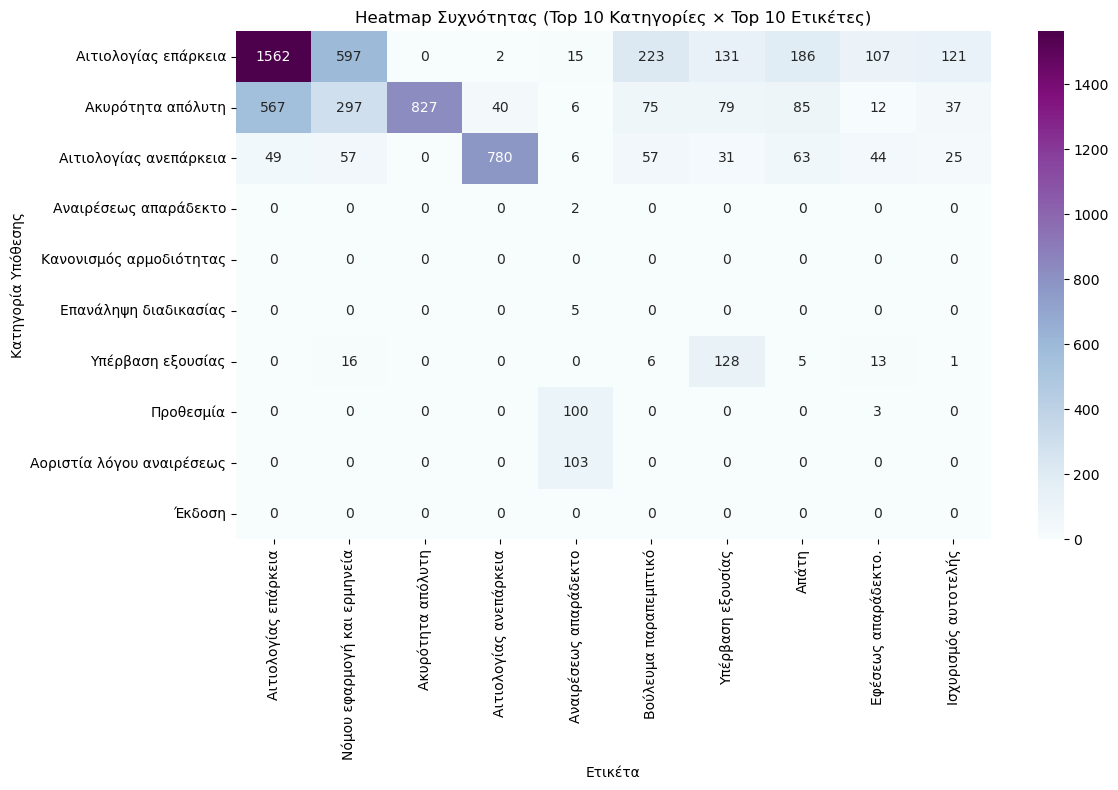

In [ ]:
print("ŒîŒ∑ŒºŒπŒøœÖœÅŒ≥ŒØŒ± heatmap Œ≥ŒπŒ± case_category √ó case_tags...")
df['clean_tags'] = df['case_tags'].dropna().apply(lambda x: [tag.strip() for tag in str(x).split(',')])
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()
tags_encoded = mlb.fit_transform(df['clean_tags'].dropna())
tags_df = pd.DataFrame(tags_encoded, columns=mlb.classes_)

top_10_tags = tags_df.sum().sort_values(ascending=False).head(10).index.tolist()
top_10_categories = case_category_counts.head(10).index.tolist()

cross_tab = pd.DataFrame(index=top_10_categories, columns=top_10_tags)

for cat in top_10_categories:
    subset = df[df['case_category'] == cat]
    tag_list = subset['clean_tags'].dropna()
    flattened = [tag for tags in tag_list for tag in tags]
    tag_counts = pd.Series(flattened).value_counts()
    for tag in top_10_tags:
        cross_tab.loc[cat, tag] = tag_counts.get(tag, 0)

cross_tab = cross_tab.fillna(0).astype(int)

plt.figure(figsize=(12, 8))
sns.heatmap(cross_tab, annot=True, fmt="d", cmap="BuPu")
plt.title("Heatmap Œ£œÖœáŒΩœåœÑŒ∑œÑŒ±œÇ (Top 10 ŒöŒ±œÑŒ∑Œ≥ŒøœÅŒØŒµœÇ √ó Top 10 ŒïœÑŒπŒ∫Œ≠œÑŒµœÇ)")
plt.ylabel("ŒöŒ±œÑŒ∑Œ≥ŒøœÅŒØŒ± Œ•œÄœåŒ∏ŒµœÉŒ∑œÇ")
plt.xlabel("ŒïœÑŒπŒ∫Œ≠œÑŒ±")
plt.tight_layout()
plt.show()

**Œ£œÖŒºœÄŒµœÅŒ¨œÉŒºŒ±œÑŒ±:** Œó Œ∫Œ±œÑŒ∑Œ≥ŒøœÅŒØŒ± "ŒëŒπœÑŒπŒøŒªŒøŒ≥ŒØŒ±œÇ ŒµœÄŒ¨œÅŒ∫ŒµŒπŒ±" Œ≠œáŒµŒπ œÑŒ∑ ŒºŒµŒ≥Œ±ŒªœçœÑŒµœÅŒ∑ œÉœÖŒΩŒøŒªŒπŒ∫ŒÆ œÉœÖŒºŒºŒµœÑŒøœáŒÆ Œ∫Œ±Œπ œÉœÖŒΩŒ¥Œ≠ŒµœÑŒ±Œπ Œ¨ŒºŒµœÉŒ± ŒºŒµ œÑŒ∑ŒΩ ŒøŒºœéŒΩœÖŒºŒ∑ ŒµœÑŒπŒ∫Œ≠œÑŒ± (1562), Œ±ŒªŒªŒ¨ Œ∫Œ±Œπ ŒºŒµ Œ¨ŒªŒªŒµœÇ œÉœÖœáŒΩŒ≠œÇ ŒµœÑŒπŒ∫Œ≠œÑŒµœÇ œåœÄœâœÇ "ŒùœåŒºŒøœÖ ŒµœÜŒ±œÅŒºŒøŒ≥ŒÆ Œ∫Œ±Œπ ŒµœÅŒºŒ∑ŒΩŒµŒØŒ±" (597), "ŒëŒΩŒ±ŒØœÅŒµœÉŒ∑œÇ Œ±œÄŒ±œÅŒ¨Œ¥ŒµŒ∫œÑŒø" (223) Œ∫Œ±Œπ "ŒíŒøœçŒªŒµœÖŒºŒ± œÄŒ±œÅŒ±œÄŒµŒºœÄœÑŒπŒ∫œå" (186). Œ†ŒøŒªŒªŒ≠œÇ Œ±œÄœå œÑŒπœÇ œÖœÄœåŒªŒøŒπœÄŒµœÇ Œ∫Œ±œÑŒ∑Œ≥ŒøœÅŒØŒµœÇ (œÄ.œá. "ŒëŒΩŒ±ŒØœÅŒµœÉŒ∑œÇ Œ±œÄŒ±œÅŒ¨Œ¥ŒµŒ∫œÑŒø", "ŒàŒ∫Œ¥ŒøœÉŒ∑") ŒµŒºœÜŒ±ŒΩŒØŒ∂ŒøœÖŒΩ ŒºŒ∑Œ¥ŒµŒΩŒπŒ∫ŒÆ ŒÆ ŒµŒªŒ¨œáŒπœÉœÑŒ∑ œÉœçŒΩŒ¥ŒµœÉŒ∑ ŒºŒµ œÑŒπœÇ Œ∫ŒøœÅœÖœÜŒ±ŒØŒµœÇ ŒµœÑŒπŒ∫Œ≠œÑŒµœÇ. ŒëœÖœÑœå œÖœÄŒøŒ¥ŒµŒπŒ∫ŒΩœçŒµŒπ œåœÑŒπ œÉœÖŒΩŒ¥Œ≠ŒøŒΩœÑŒ±Œπ ŒºŒµ œÉœÄŒ±ŒΩŒπœåœÑŒµœÅŒµœÇ ŒµœÑŒπŒ∫Œ≠œÑŒµœÇ œÄŒøœÖ Œ¥ŒµŒΩ ŒµŒºœÜŒ±ŒΩŒØŒ∂ŒøŒΩœÑŒ±Œπ ŒµŒ¥œé.

# B2.ii

In [ ]:
# Convert case_tags to list of tags
df['case_tags'] = df['case_tags'].fillna('').apply(
    lambda x: [tag.strip() for tag in x.split(',')] if isinstance(x, str) else x
)

# Filtering the tags
all_tags = [tag for tags in df['case_tags'] for tag in tags]
tag_counts = Counter(all_tags)
valid_tag_set = {tag for tag, count in tag_counts.items() if count >= 5}

#filtering the categories
cat_counts = df['case_category'].value_counts()
valid_cats = cat_counts[cat_counts >= 5].index

def has_valid_tag(tag_list):
    return any(tag in valid_tag_set for tag in tag_list)

# filtering the DataFrame
df_filtered = df[
    df['case_category'].isin(valid_cats) &
    df['case_tags'].apply(has_valid_tag)
].copy()

## Test Embeddings

**Œ£Œ∑ŒºŒ≠ŒπœâœÉŒ∑:** ŒìŒπŒ± œÑŒ∑ŒΩ Œ±ŒæŒπŒøŒªœåŒ≥Œ∑œÉŒ∑ œÑœâŒΩ embedding œáœÅŒ∑œÉŒπŒºŒøœÄŒøŒπŒÆœÉŒ± œÑŒø case_category Œ≥ŒπŒ±œÑŒØ ŒµŒØŒΩŒ±Œπ single-label classification, œÄŒøœÖ Œ¥ŒøœÖŒªŒµœçŒµŒπ Œ¨ŒºŒµœÉŒ± ŒºŒµ LinearSVC, œÉŒµ œÉœáŒµœÉŒ∑ ŒºŒµ œÑŒø case_tags œÄŒøœÖ ŒµŒØŒΩŒ±Œπ multimodel.

In [ ]:
X = df_filtered['text']
y = df_filtered['case_category']
le = LabelEncoder()
y_enc = le.fit_transform(y)

#Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y_enc, test_size=0.2, stratify=y_enc, random_state=42
)

#TF-IDF Vectorization
print("Vectorizing texts with TF-IDF...")
tfidf = TfidfVectorizer(max_features=10000, stop_words=stopwords_el)
X_train_vec = tfidf.fit_transform(X_train)
X_test_vec = tfidf.transform(X_test)

#SVM Classification
print("Training SVM...")
svm = LinearSVC()
svm.fit(X_train_vec, y_train)
y_pred = svm.predict(X_test_vec)



metrics_df = pd.DataFrame([{
    'Accuracy': accuracy_score(y_test, y_pred),
    'Precision (macro)': precision_score(y_test, y_pred, average='macro', zero_division=0),
    'Recall (macro)': recall_score(y_test, y_pred, average='macro', zero_division=0),
    'F1-score (macro)': f1_score(y_test, y_pred, average='macro', zero_division=0),
    'Precision (weighted)': precision_score(y_test, y_pred, average='weighted', zero_division=0),
    'Recall (weighted)': recall_score(y_test, y_pred, average='weighted', zero_division=0),
    'F1-score (weighted)': f1_score(y_test, y_pred, average='weighted', zero_division=0)
}], index=['SVM + TF-IDF'])

display(metrics_df)

Vectorizing texts with TF-IDF...
Training SVM...


Accuracy  Precision (macro)  Recall (macro)  F1-score (macro)  \
SVM + TF-IDF  0.692573           0.300777           0.287          0.282042   

              Precision (weighted)  Recall (weighted)  F1-score (weighted)  
SVM + TF-IDF              0.637868           0.692573             0.650244

In [ ]:
stopwords_el = set(stopwords_el)

X = df_filtered['text']
y = df_filtered['case_category']
le = LabelEncoder()
y_enc = le.fit_transform(y)

X_train_texts, X_test_texts, y_train, y_test = train_test_split(
    X, y_enc, test_size=0.2, stratify=y_enc, random_state=42
)

# loading the fastText model
print("Loading fastText model...")
ft_model = load_facebook_vectors("cc.el.300.bin")

# Compute embeddings
def compute_embeddings(texts, model, stopwords, dim=300):
    vectors = []
    for doc in texts:
        tokens = [w for w in doc.split() if w not in stopwords and w in model]
        if tokens:
            vec = np.mean([model[w] for w in tokens], axis=0)
        else:
            vec = np.zeros(dim)
        vectors.append(vec)
    return np.array(vectors)

print(" Computing embeddings...")
X_train_vecs = compute_embeddings(X_train_texts, ft_model, stopwords_el)
X_test_vecs = compute_embeddings(X_test_texts, ft_model, stopwords_el)

# SVM Classification
print("Training SVM...")
clf = LinearSVC()
clf.fit(X_train_vecs, y_train)
y_pred = clf.predict(X_test_vecs)

metrics_df = pd.DataFrame([{
    'Accuracy': accuracy_score(y_test, y_pred),
    'Precision (macro)': precision_score(y_test, y_pred, average='macro', zero_division=0),
    'Recall (macro)': recall_score(y_test, y_pred, average='macro', zero_division=0),
    'F1-score (macro)': f1_score(y_test, y_pred, average='macro', zero_division=0),
    'Precision (weighted)': precision_score(y_test, y_pred, average='weighted', zero_division=0),
    'Recall (weighted)': recall_score(y_test, y_pred, average='weighted', zero_division=0),
    'F1-score (weighted)': f1_score(y_test, y_pred, average='weighted', zero_division=0)
}], index=['SVM + fastText'])

display(metrics_df)


Loading fastText model...
 Computing embeddings...
Training SVM...


Accuracy  Precision (macro)  Recall (macro)  F1-score (macro)  \
SVM + fastText  0.363558            0.04822        0.037134          0.030146   

                Precision (weighted)  Recall (weighted)  F1-score (weighted)  
SVM + fastText              0.261255           0.363558             0.237708

In [ ]:
stopwords_el = set(stopwords_el)

X = df_filtered['text']
y = df_filtered['case_category']
le = LabelEncoder()
y_enc = le.fit_transform(y)

X_train_texts, X_test_texts, y_train, y_test = train_test_split(
    X, y_enc, test_size=0.2, stratify=y_enc, random_state=42
)

# loading the Word2Vec model
print("Loading Word2Vec embeddings...")
model = KeyedVectors.load_word2vec_format("cc.el.300.vec", binary=False)
dim = model.vector_size

# Compute embeddings
def text_to_vector(text, model, stopwords, dim):
    words = re.findall(r'\w+', text.lower())
    words = [w for w in words if clean_text(w) not in stopwords]
    vectors = [model[w] for w in words if w in model]
    return np.mean(vectors, axis=0) if vectors else np.zeros(dim)

print("Vectorizing texts...")
X_train_vecs = np.stack([text_to_vector(t, model, stopwords_el, dim) for t in X_train_texts])
X_test_vecs = np.stack([text_to_vector(t, model, stopwords_el, dim) for t in X_test_texts])

# SVM Classification
print(" Training SVM...")
svm = LinearSVC()
svm.fit(X_train_vecs, y_train)
y_pred = svm.predict(X_test_vecs)

metrics_df = pd.DataFrame([{
    'Accuracy': accuracy_score(y_test, y_pred),
    'Precision (macro)': precision_score(y_test, y_pred, average='macro', zero_division=0),
    'Recall (macro)': recall_score(y_test, y_pred, average='macro', zero_division=0),
    'F1-score (macro)': f1_score(y_test, y_pred, average='macro', zero_division=0),
    'Precision (weighted)': precision_score(y_test, y_pred, average='weighted', zero_division=0),
    'Recall (weighted)': recall_score(y_test, y_pred, average='weighted', zero_division=0),
    'F1-score (weighted)': f1_score(y_test, y_pred, average='weighted', zero_division=0)
}], index=['SVM + Word2Vec'])

display(metrics_df)


Loading Word2Vec embeddings...
Vectorizing texts...
 Training SVM...


Accuracy  Precision (macro)  Recall (macro)  F1-score (macro)  \
SVM + Word2Vec    0.3821           0.044382        0.041015          0.035289   

                Precision (weighted)  Recall (weighted)  F1-score (weighted)  
SVM + Word2Vec              0.274264             0.3821              0.26369

In [ ]:
stopwords_el = set(stopwords_el)

X = df_filtered['text']
y = df_filtered['case_category']
le = LabelEncoder()
y_enc = le.fit_transform(y)

X_train_texts, X_test_texts, y_train, y_test = train_test_split(
    X, y_enc, test_size=0.2, stratify=y_enc, random_state=42
)

# Loading GloVe embeddings
print(" Loading GloVe vectors...")
glove_path = "glove.6B.300d.txt"
embeddings_index = {}
with open(glove_path, encoding="utf-8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = vector
dim = len(vector)

# Compute embeddings
def text_to_vector_glove(text, embeddings, stopwords, dim):
    words = re.findall(r'\w+', text.lower())
    words = [w for w in words if clean_text(w) not in stopwords]
    vectors = [embeddings[w] for w in words if w in embeddings]
    return np.mean(vectors, axis=0) if vectors else np.zeros(dim)

print("Vectorizing texts...")
X_train_vecs = np.stack([text_to_vector_glove(t, embeddings_index, stopwords_el, dim) for t in X_train_texts])
X_test_vecs = np.stack([text_to_vector_glove(t, embeddings_index, stopwords_el, dim) for t in X_test_texts])

# SVM Classification
print("Training SVM...")
svm = LinearSVC()
svm.fit(X_train_vecs, y_train)
y_pred = svm.predict(X_test_vecs)

metrics_df = pd.DataFrame([{
    'Accuracy': accuracy_score(y_test, y_pred),
    'Precision (macro)': precision_score(y_test, y_pred, average='macro', zero_division=0),
    'Recall (macro)': recall_score(y_test, y_pred, average='macro', zero_division=0),
    'F1-score (macro)': f1_score(y_test, y_pred, average='macro', zero_division=0),
    'Precision (weighted)': precision_score(y_test, y_pred, average='weighted', zero_division=0),
    'Recall (weighted)': recall_score(y_test, y_pred, average='weighted', zero_division=0),
    'F1-score (weighted)': f1_score(y_test, y_pred, average='weighted', zero_division=0)
}], index=['SVM + GloVe'])

display(metrics_df)


 Loading GloVe vectors...
Vectorizing texts...
Training SVM...


c:\Users\Maria\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Accuracy  Precision (macro)  Recall (macro)  F1-score (macro)  \
SVM + GloVe  0.291738           0.044934        0.037419          0.035107   

             Precision (weighted)  Recall (weighted)  F1-score (weighted)  
SVM + GloVe              0.191106           0.291738             0.194996

## Find the best K for K-means

In [ ]:
print("Vectorizing with TF-IDF...")
vectorizer = TfidfVectorizer(max_features=10000, stop_words=stopwords_el)
X_all = vectorizer.fit_transform(df_filtered['text_clean'])

Vectorizing with TF-IDF...


Evaluating KMeans for different K values...


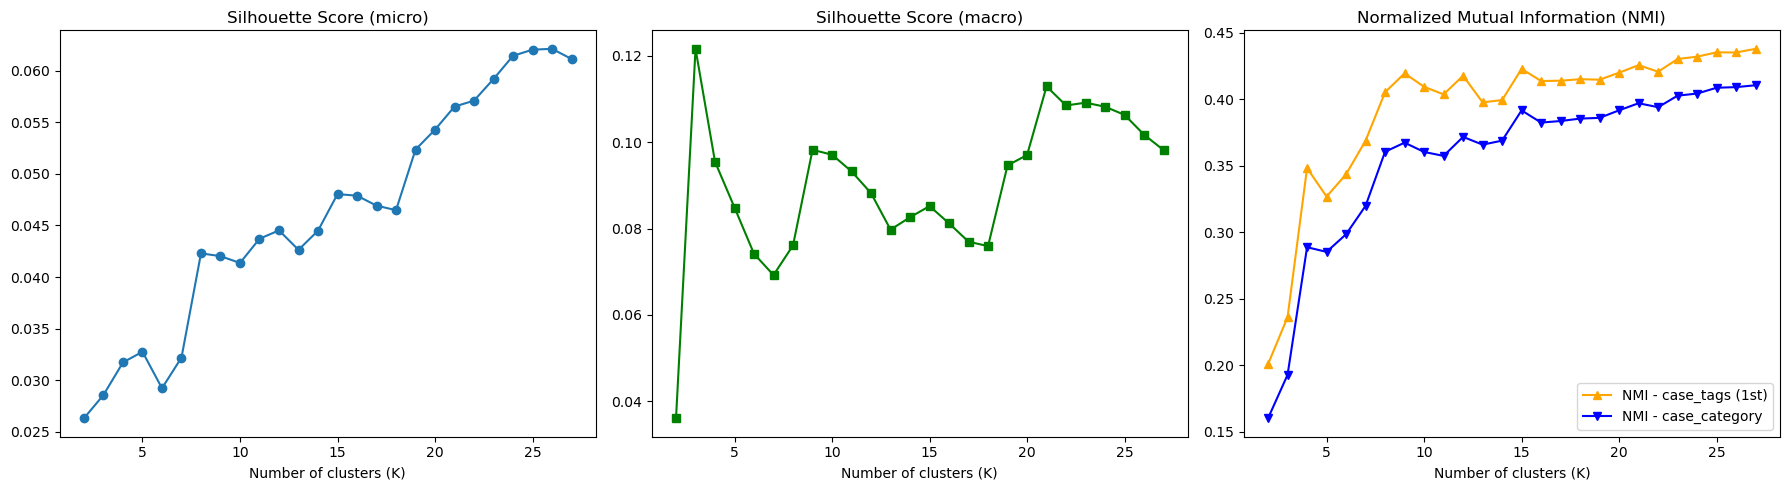

In [ ]:
le_cat = LabelEncoder()
y_cat = le_cat.fit_transform(df_filtered['case_category'])

df_filtered['tag_single'] = df_filtered['case_tags'].apply(lambda tags: tags[0] if tags else 'NO_TAG')
le_tag = LabelEncoder()
y_tag = le_tag.fit_transform(df_filtered['tag_single'])

# KMeans Clustering
k_values = list(range(2, 28))
sil_scores = []
macro_scores = []
nmi_scores_cat = []
nmi_scores_tag = []

print("Evaluating KMeans for different K values...")
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    cluster_labels = kmeans.fit_predict(X_all)

    # Silhouette (micro)
    sil = silhouette_score(X_all, cluster_labels)

    # Silhouette (macro)
    sample_sil = silhouette_samples(X_all, cluster_labels)
    macro_sil = np.mean([
        sample_sil[cluster_labels == label].mean()
        for label in np.unique(cluster_labels)
        if np.sum(cluster_labels == label) > 1
    ]) if len(np.unique(cluster_labels)) > 1 else 0

    # NMI
    nmi_cat = normalized_mutual_info_score(y_cat, cluster_labels)
    nmi_tag = normalized_mutual_info_score(y_tag, cluster_labels)

    # Save scores
    sil_scores.append(sil)
    macro_scores.append(macro_sil)
    nmi_scores_cat.append(nmi_cat)
    nmi_scores_tag.append(nmi_tag)

# Plotting the results
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].plot(k_values, sil_scores, marker='o')
axes[0].set_title("Silhouette Score (micro)")
axes[0].set_xlabel("Number of clusters (K)")

axes[1].plot(k_values, macro_scores, marker='s', color='green')
axes[1].set_title("Silhouette Score (macro)")
axes[1].set_xlabel("Number of clusters (K)")

axes[2].plot(k_values, nmi_scores_tag, marker='^', color='orange', label='NMI - case_tags (1st)')
axes[2].plot(k_values, nmi_scores_cat, marker='v', color='blue', label='NMI - case_category')
axes[2].set_title("Normalized Mutual Information (NMI)")
axes[2].set_xlabel("Number of clusters (K)")
axes[2].legend()

plt.tight_layout()
plt.show()

- Silhouette Score (micro): ŒëœÖŒæŒ¨ŒΩŒµœÑŒ±Œπ œÉœÑŒ±Œ¥ŒπŒ±Œ∫Œ¨, Œ∫ŒøœÅœÖœÜŒÆ œÉœÑŒø K=25.

- Silhouette Score (macro): Œ•œàŒ∑ŒªœåœÑŒµœÅŒµœÇ œÑŒπŒºŒ≠œÇ œÉœÑŒø K=3,21.

- NMI: Œ£œÑŒ±Œ∏ŒµœÅŒøœÄŒøŒØŒ∑œÉŒ∑ ŒºŒµœÑŒ¨ œÑŒø K=15,œÉœÑŒø K=21 œÄŒ±œÅŒ±œÑŒ∑œÅŒµŒØœÑŒµ œÄŒ±ŒªŒπ ŒºŒπŒ± ŒºŒπŒ∫œÅŒÆ Œ±œçŒæŒ∑œÉŒ∑,Œ∫Œ±ŒªœçœÑŒµœÅŒ∑ œÉœÖœÉœáŒ≠œÑŒπœÉŒ∑ ŒºŒµ case_tags.

 t-SNE...


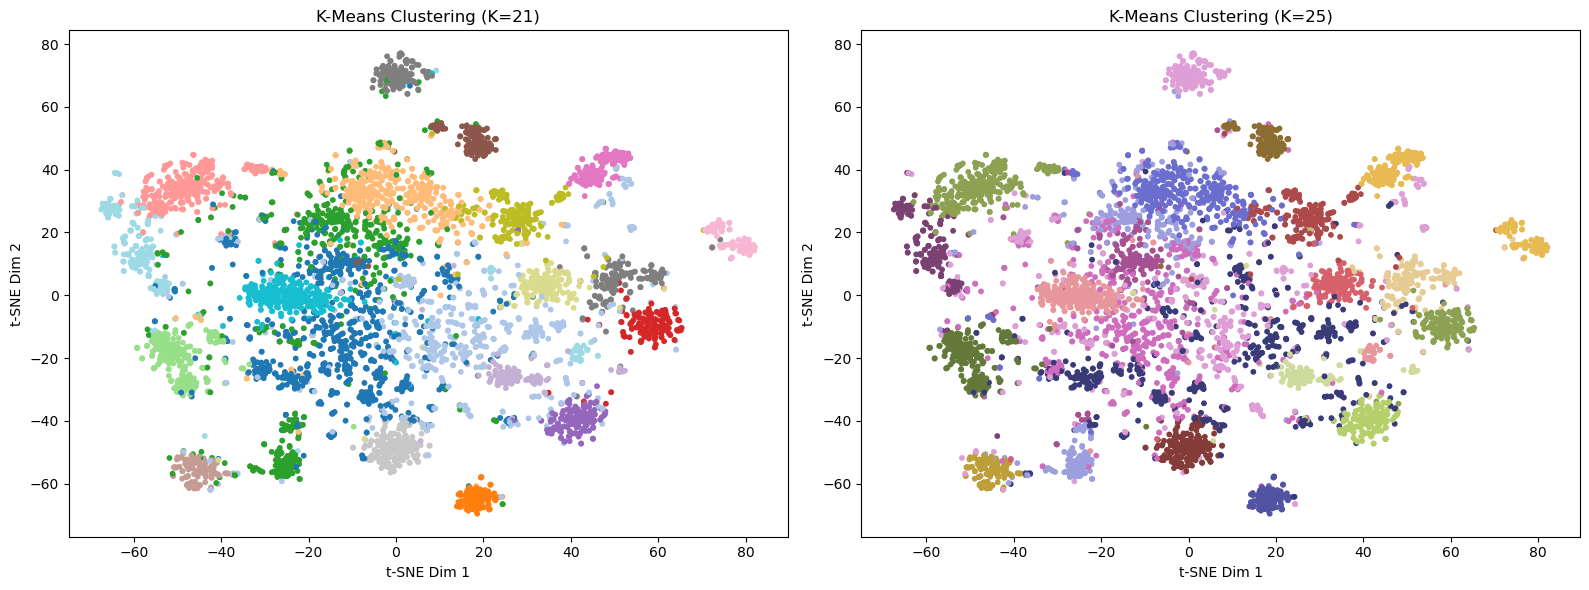

In [ ]:
# kmeans with K=21 and K=25
kmeans_21 = KMeans(n_clusters=21, random_state=0, n_init='auto').fit(X_all)
labels_21 = kmeans_21.labels_

kmeans_25 = KMeans(n_clusters=25, random_state=0, n_init='auto').fit(X_all)
labels_25 = kmeans_25.labels_

# t-SNE
print(" t-SNE...")
tsne = TSNE(n_components=2, perplexity=30, random_state=0)
X_embedded = tsne.fit_transform(X_all.toarray())

# Plotting the clusters
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: K=21
axes[0].scatter(X_embedded[:, 0], X_embedded[:, 1], c=labels_21, cmap='tab20', s=10)
axes[0].set_title("K-Means Clustering (K=21)")
axes[0].set_xlabel("t-SNE Dim 1")
axes[0].set_ylabel("t-SNE Dim 2")

# Plot 2: K=25
axes[1].scatter(X_embedded[:, 0], X_embedded[:, 1], c=labels_25, cmap='tab20b', s=10)
axes[1].set_title("K-Means Clustering (K=25)")
axes[1].set_xlabel("t-SNE Dim 1")
axes[1].set_ylabel("t-SNE Dim 2")

plt.tight_layout()
plt.show()


ŒëœÅŒπœÉœÑŒµœÅœå Œ¥ŒπŒ¨Œ≥œÅŒ±ŒºŒºŒ± (K = 21)
- ŒüŒπ œÉœÖœÉœÑŒ¨Œ¥ŒµœÇ ŒµŒØŒΩŒ±Œπ œÄŒπŒø œÉœÖŒΩŒµŒ∫œÑŒπŒ∫Œ≠œÇ Œ∫Œ±Œπ ŒπœÉŒøœÅœÅŒøœÄŒ∑ŒºŒ≠ŒΩŒµœÇ, ŒºŒµ Œ±œÅŒ∫ŒµœÑŒ¨ Œ∫Œ±Œ∏Œ±œÅœå Œ¥ŒπŒ±œáœâœÅŒπœÉŒºœå.
- Œ•œÄŒ¨œÅœáŒµŒπ ŒºŒπŒ∫œÅœåœÑŒµœÅŒ∑ ŒµœÄŒπŒ∫Œ¨ŒªœÖœàŒ∑, Œ≥ŒµŒ≥ŒøŒΩœåœÇ œÄŒøœÖ Œ¥ŒπŒµœÖŒ∫ŒøŒªœçŒΩŒµŒπ œÑŒ∑ Œ∏ŒµŒºŒ±œÑŒπŒ∫ŒÆ œÉœÖŒΩŒøœáŒÆ Œ∫Œ±Œπ œÑŒ∑ŒΩ ŒµœÅŒºŒ∑ŒΩŒµœÖœÉŒπŒºœåœÑŒ∑œÑŒ± œÑœâŒΩ ŒøŒºŒ¨Œ¥œâŒΩ.

ŒîŒµŒæŒØ Œ¥ŒπŒ¨Œ≥œÅŒ±ŒºŒºŒ± (K = 25)
- ŒüŒπ œÉœÖœÉœÑŒ¨Œ¥ŒµœÇ ŒµŒØŒΩŒ±Œπ œÄŒµœÅŒπœÉœÉœåœÑŒµœÅŒµœÇ Œ∫Œ±Œπ ŒºŒπŒ∫œÅœåœÑŒµœÅŒµœÇ, ŒºŒµ ŒøœÅŒπœÉŒºŒ≠ŒΩŒµœÇ ŒΩŒ± ŒµŒØŒΩŒ±Œπ œÄŒøŒªœç Œ∫Œ±Œ∏Œ±œÅŒ≠œÇ œÄŒµœÅŒπœÜŒµœÅŒµŒπŒ±Œ∫Œ¨ (Œ∫œÖœÅŒπŒµœÇ Œ±œÖœÑŒµœÇ œÄŒøœÖ ŒµŒπŒΩŒ±Œπ ŒºŒ±Œ∫œÅŒπŒ¨ Œ±œÄŒø œÑŒø Œ∫Œ≠ŒΩœÑœÅŒø)
‚ñ∏ Œ†Œ±œÅŒ±œÑŒ∑œÅŒµŒØœÑŒ±Œπ œÖœÄŒµœÅœÉœÖœÉœÉœéœÅŒµœÖœÉŒ∑ Œ∫Œ±Œπ ŒµœÄŒπŒ∫Œ¨ŒªœÖœàŒ∑ œÉœÑŒø Œ∫Œ≠ŒΩœÑœÅŒø, Œ≥ŒµŒ≥ŒøŒΩœåœÇ œÄŒøœÖ ŒµŒΩŒ¥Œ≠œáŒµœÑŒ±Œπ ŒΩŒ± œÖœÄŒøŒ¥ŒµŒπŒ∫ŒΩœçŒµŒπ œÖœÄŒµœÅŒ∫Œ±œÑŒ±Œ∫ŒµœÅŒºŒ±œÑŒπœÉŒºœå Œ∫Œ±Œπ ŒΩŒ± Œ¥œÖœÉŒ∫ŒøŒªŒµœçŒµŒπ œÑŒ∑ Œ¥Œ∑ŒºŒπŒøœÖœÅŒ≥ŒØŒ± ŒæŒµŒ∫Œ¨Œ∏Œ±œÅœâŒΩ œÑŒØœÑŒªœâŒΩ.

Œ£œÖŒΩŒµœÄœéœÇ, Œ∑ œÑŒπŒºŒÆ K=21 œÜŒ±ŒØŒΩŒµœÑŒ±Œπ ŒΩŒ± œÄœÅŒøœÉœÜŒ≠œÅŒµŒπ Œ∫Œ±ŒªœçœÑŒµœÅŒ∑ ŒπœÉŒøœÅœÅŒøœÄŒØŒ± ŒºŒµœÑŒ±Œæœç Œ¥ŒπŒ±Œ∫œÅŒπœÑœåœÑŒ∑œÑŒ± Œ∫Œ±Œπ œÉœÑŒ±Œ∏ŒµœÅœåœÑŒ∑œÑŒ±œÇ œÑœâŒΩ œÉœÖœÉœÑŒ¨Œ¥œâŒΩ, Œ∫Œ¨œÑŒπ œÄŒøœÖ ŒµœÄŒπŒ≤ŒµŒ≤Œ±ŒπœéŒΩŒµœÑŒ±Œπ Œ∫Œ±Œπ Œ±œÄœå œÑŒπœÇ Œ±ŒΩœÑŒØœÉœÑŒøŒπœáŒµœÇ ŒºŒµœÑœÅŒπŒ∫Œ≠œÇ Silhouette Œ∫Œ±Œπ NMI

# B2.iii

In [ ]:
kmeans_21 = KMeans(n_clusters=21, random_state=0, n_init='auto').fit(X_all)
labels_21 = kmeans_21.labels_
df_filtered["cluster"] = labels_21

In [ ]:
# Œ¶œåœÅœÑœâœÉŒ∑ Llama-Krikri
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "ilsp/Llama-Krikri-8B-Instruct",
    max_seq_length = 2048,
    dtype = torch.float16,
    load_in_4bit = True,
)
model = FastLanguageModel.get_peft_model(model)


ü¶• Unsloth: Will patch your computer to enable 2x faster free finetuning.
ü¶• Unsloth Zoo will now patch everything to make training faster!
==((====))==  Unsloth 2025.5.6: Fast Llama patching. Transformers: 4.51.3.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.7.0+cu126. CUDA: 7.5. CUDA Toolkit: 12.6. Triton: 3.3.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.30. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.91G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.57G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/184 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/55.5k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/19.5M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/752 [00:00<?, ?B/s]

Unsloth 2025.5.6 patched 32 layers with 32 QKV layers, 32 O layers and 32 MLP layers.


In [ ]:
def make_prompt(texts):
    example = (
        "Œ†Œ±œÅŒ¨Œ¥ŒµŒπŒ≥ŒºŒ±:\n"
        "ŒöŒµŒØŒºŒµŒΩŒø: Œü ŒµœÅŒ≥Œ±Œ∂œåŒºŒµŒΩŒøœÇ Œ±œÄŒøŒªœçŒ∏Œ∑Œ∫Œµ œáœâœÅŒØœÇ œÄœÅŒøŒµŒπŒ¥ŒøœÄŒøŒØŒ∑œÉŒ∑ ŒªœåŒ≥œâ Œ±œÄŒøœÖœÉŒπœéŒΩ.\n"
        "ŒòŒ≠ŒºŒ±:\nŒëœÄŒøŒ∂Œ∑ŒºŒØœâœÉŒ∑ ŒªœåŒ≥œâ Œ∫Œ±œÑŒ±œáœÅŒ∑œÉœÑŒπŒ∫ŒÆœÇ Œ±œÄœåŒªœÖœÉŒ∑œÇ\n\n"
    )
    joined_texts = "\n\n".join(texts)
    return (
        f"{example}"
        f"ŒöŒµŒØŒºŒµŒΩŒø: {joined_texts}\n"
        "ŒòŒ≠ŒºŒ±:\n"
    )

def get_llm_response(texts):
    prompt = make_prompt(texts)
    inputs = tokenizer(prompt, return_tensors="pt").to("cuda")
    outputs = model.generate(**inputs, max_new_tokens=100, temperature=0.7)
    return tokenizer.decode(outputs[0], skip_special_tokens=True)

In [ ]:
def extract_main_theme(response):
    matches = re.findall(r"ŒòŒ≠ŒºŒ±[:Ôºö]\s*(.*?)(?:\n|\\n|ŒöŒµŒØŒºŒµŒΩŒø:|$)", response, re.DOTALL)

    if len(matches) > 1:
        theme = matches[1]
        theme_clean = theme.replace("\\n", " ").replace("‚Ä¶", "").strip(" \n.'-\"")

        if len(theme_clean.split()) < 2 or theme_clean.lower() in {"Œ±ŒΩŒ±ŒπœÅŒµœÉŒØŒ≤ŒªŒ∑œÑŒøœÇ", "Œ±Œ≥œâŒ≥ŒÆ"}:
            return "‚ö†Ô∏è ŒëœÉŒ±œÜŒ≠œÇ Œ∏Œ≠ŒºŒ±"
        return theme_clean

    return "‚ö†Ô∏è ŒîŒµŒΩ ŒµŒΩœÑŒøœÄŒØœÉœÑŒ∑Œ∫Œµ Œ∏Œ≠ŒºŒ±"


In [ ]:
def get_samples_for_cluster(cluster_id, n_samples=3):

    cluster_mask = df_filtered["cluster"] == cluster_id
    cluster_positions = np.where(cluster_mask)[0]

    X_cluster = X_all[cluster_positions]
    centroid = kmeans_21.cluster_centers_[cluster_id].reshape(1, -1)

    distances = pairwise_distances(X_cluster, centroid)
    sorted_indices = np.argsort(distances.ravel())

    closest_pos = cluster_positions[sorted_indices[:n_samples]]
    random_pos = np.random.choice(cluster_positions, size=n_samples, replace=False)

    return df_filtered.iloc[closest_pos]["summary"].tolist(), df_filtered.iloc[random_pos]["summary"].tolist()


In [ ]:
def format_output_single_theme(response, original_texts):
    theme = extract_main_theme(response)
    joined_text = "\n\n".join(original_texts)
    return f"ŒòŒ≠ŒºŒ±:\n{theme}\n\nŒ§Œø Œ∫ŒµŒØŒºŒµŒΩŒø ŒµŒØŒΩŒ±Œπ Œ±œÖœÑœå:\n{joined_text}"

In [ ]:
for cluster_id in range(21):
    close_texts, random_texts = get_samples_for_cluster(cluster_id)

    # LLM responses
    response_close = get_llm_response(close_texts)
    response_random = get_llm_response(random_texts)

    # Main theme extraction
    theme_close = extract_main_theme(response_close)
    theme_random = extract_main_theme(response_random)

    # Output formatting
    print(f"\n==================== Cluster {cluster_id + 1} ====================")

    print("\n‚û°Ô∏è ŒëœÄœå Œ±œÄŒøœÜŒ¨œÉŒµŒπœÇ Œ∫ŒøŒΩœÑŒ¨ œÉœÑŒø Œ∫Œ≠ŒΩœÑœÅŒø:")
    print("ŒòŒ≠ŒºŒ±:")
    print(theme_close)
    print("Œ§Œø Œ∫ŒµŒØŒºŒµŒΩŒø ŒµŒØŒΩŒ±Œπ Œ±œÖœÑœå:")
    print("\n\n".join(close_texts))

    print("\n‚û°Ô∏è ŒëœÄœå œÑœÖœáŒ±ŒØŒµœÇ Œ±œÄŒøœÜŒ¨œÉŒµŒπœÇ:")
    print("ŒòŒ≠ŒºŒ±:")
    print(theme_random)
    print("Œ§Œø Œ∫ŒµŒØŒºŒµŒΩŒø ŒµŒØŒΩŒ±Œπ Œ±œÖœÑœå:")
    print("\n\n".join(random_texts))



==================== Cluster 1 ====================

‚û°Ô∏è ŒëœÄœå Œ±œÄŒøœÜŒ¨œÉŒµŒπœÇ Œ∫ŒøŒΩœÑŒ¨ œÉœÑŒø Œ∫Œ≠ŒΩœÑœÅŒø:
ŒòŒ≠ŒºŒ±:
Œ•œÄŒµœÅŒ≤ŒøŒªŒπŒ∫ŒÆ Œ±ŒπœÑŒπŒøŒªŒøŒ≥ŒØŒ± Œ∫Œ±Œπ œÖœÄŒ≠œÅŒ≤Œ±œÉŒ∑ ŒµŒæŒøœÖœÉŒØŒ±œÇ
Œ§Œø Œ∫ŒµŒØŒºŒµŒΩŒø ŒµŒØŒΩŒ±Œπ Œ±œÖœÑœå:
ŒöŒ±œÑŒ±Œ¥ŒπŒ∫Œ±œÉœÑŒπŒ∫ŒÆ Œ±œÄœåœÜŒ±œÉŒ∑ Œ≥ŒπŒ± œÄŒªŒ±œÉœÑŒøŒ≥œÅŒ±œÜŒØŒ± ŒºŒµ œáœÅŒÆœÉŒ∑ Œ∫Œ±œÑ' ŒµŒæŒ±Œ∫ŒøŒªŒøœçŒ∏Œ∑œÉŒ∑. ŒëŒΩœÑŒπŒ∫ŒµŒØŒºŒµŒΩŒø œÄŒªŒ±œÉœÑŒøŒ≥œÅŒ±œÜŒØŒ±œÇ ŒµŒØŒΩŒ±Œπ Œ∫Œ±Œπ œÑŒø œÜœâœÑŒøœÑœÖœÄŒπŒ∫œå Œ±ŒΩœÑŒØŒ≥œÅŒ±œÜŒø ŒµŒ≥Œ≥œÅŒ¨œÜŒøœÖ. Œ†œåœÑŒµ Œ±œÅœáŒØŒ∂ŒµŒπ Œ∑ Œ∫œçœÅŒπŒ± Œ¥ŒπŒ±Œ¥ŒπŒ∫Œ±œÉŒØŒ±. Œ†œÅŒøœÉœÜœÖŒ≥ŒÆ Œ∫Œ±œÑŒ¨ œÑŒøœÖ Œ∫ŒªŒ∑œÑŒ∑œÅŒØŒøœÖ Œ∏ŒµœÉœÄŒØœÉŒºŒ±œÑŒøœÇ. ŒåœÑŒ±ŒΩ Œ≥ŒØŒΩŒµŒπ Œ¥ŒµŒ∫œÑŒÆ Œ∑ œÄœÅŒøœÉœÜœÖŒ≥ŒÆ Œ∫Œ±Œπ œÄŒ±œÅŒ±œÄŒµŒºœÜŒ∏ŒµŒØ Œ∑ œÖœÄœåŒ∏ŒµœÉŒ∑ œÉœÑŒø œÉœÖŒºŒ≤ŒøœçŒªŒπŒø, ŒºœåŒΩŒø Œ±œÄœå œÑŒ∑ŒΩ Œ∫ŒªŒÆœÑŒµœÖœÉŒ∑ œÑŒøœÖ Œ∫Œ±œÑŒ∑Œ≥ŒøœÅŒøœÖŒºŒ≠ŒΩŒøœÖ ŒºŒµœÑŒ¨ œÑŒø œÄŒ±œÅŒ±œÄŒµŒºœÄœÑŒπŒ∫œå Œ≤ŒøœçŒªŒµœÖŒºŒ± Œ±œÅœáŒØŒ∂ŒµŒπ Œ∑ Œ∫œçœÅŒπŒ± Œ¥ŒπŒ±Œ¥ŒπŒ∫Œ±œÉŒØŒ± Œ∫Œ±Œπ ŒµœÄŒ≠œÅœáŒµœÑŒ±Œπ Œ∑ Œ±ŒΩŒ±œÉœÑŒøŒªŒÆ œÑ

Unsloth: Input IDs of length 2231 > the model's max sequence length of 2048.
We shall truncate it ourselves. It's imperative if you correct this issue first.



==================== Cluster 5 ====================

‚û°Ô∏è ŒëœÄœå Œ±œÄŒøœÜŒ¨œÉŒµŒπœÇ Œ∫ŒøŒΩœÑŒ¨ œÉœÑŒø Œ∫Œ≠ŒΩœÑœÅŒø:
ŒòŒ≠ŒºŒ±:
Œ†œÅŒøŒ∏ŒµœÉŒºŒØŒµœÇ Œ¨œÉŒ∫Œ∑œÉŒ∑œÇ ŒµŒΩŒ¥ŒØŒ∫œâŒΩ ŒºŒ≠œÉœâŒΩ - ŒõœåŒ≥ŒøŒπ Œ±ŒΩœâœÑŒ≠œÅŒ±œÇ Œ≤ŒØŒ±œÇ
Œ§Œø Œ∫ŒµŒØŒºŒµŒΩŒø ŒµŒØŒΩŒ±Œπ Œ±œÖœÑœå:
ŒëœÄœåœÅœÅŒπœàŒ∑ Œ±ŒØœÑŒ∑œÉŒ∑œÇ Œ±ŒΩŒ±ŒØœÅŒµœÉŒ∑œÇ œâœÇ Œ±œÄŒ±œÅŒ¨Œ¥ŒµŒ∫œÑŒ∑œÇ ŒªœåŒ≥œâ ŒµŒ∫œÄœÅœåŒ∏ŒµœÉŒºŒ∑œÇ Œ¨œÉŒ∫Œ∑œÉŒÆœÇ œÑŒ∑œÇ ŒºŒµœÑŒ¨ œÑŒ∑ŒΩ œÄŒ¨œÅŒøŒ¥Œø 10Œ∑ŒºŒµœÅŒ∑œÇ œÄœÅŒøŒ∏ŒµœÉŒºŒØŒ±œÇ Œ±œÄœå œÑŒ∑ŒΩ ŒµœÄŒØŒ¥ŒøœÉŒ∑ œÉ' Œ±œÖœÑœåŒΩ œÑŒ∑œÇ œÄœÅŒøœÉŒ≤Œ±ŒªŒªœåŒºŒµŒΩŒ∑œÇ Œ±œÄœåœÜŒ±œÉŒ∑œÇ, Œ∑ ŒøœÄŒøŒØŒ± ŒµŒØœáŒµ Œ∫Œ±œÑŒ±œáœâœÅŒ∑Œ∏ŒµŒØ Œ∫Œ±Œ∏Œ±œÅŒøŒ≥ŒµŒ≥œÅŒ±ŒºŒºŒ≠ŒΩŒ∑ œÄœÅŒπŒΩ Œ±œÄœå œÑŒ∑ŒΩ ŒµœÄŒØŒ¥ŒøœÉŒ∑ œÉ' Œ±œÖœÑœåŒΩ œÉœÑŒø ŒµŒπŒ¥ŒπŒ∫œå Œ≤ŒπŒ≤ŒªŒØŒø œÄŒøœÖ œÑŒ∑œÅŒµŒØœÑŒ±Œπ œÉœÑŒ∑ Œ≥œÅŒ±ŒºŒºŒ±œÑŒµŒØŒ± œÑŒøœÖ ŒµŒ∫Œ¥œéœÉŒ±ŒΩœÑŒøœÇ Œ±œÖœÑŒÆ Œ¥ŒπŒ∫Œ±œÉœÑŒ∑œÅŒØŒøœÖ Œ∫Œ±Œπ ŒºŒ∑ Œ±ŒΩŒ±œÜŒøœÅŒ¨œÇ œÉœÑŒ∑ŒΩ Œ±ŒØœÑŒ∑œÉŒ∑ ŒªœåŒ≥œâŒΩ Œ±ŒΩœâœÑŒ≠œÅŒ±œÇ Œ≤ŒØŒ±œÇ Œ∫Œ±Œπ Œ±ŒΩœÖœÄŒ≠œÅŒ≤ŒªŒ∑œÑŒøœÖ Œ∫œâŒªœçŒºŒ±œÑŒøœÇ œÄŒøœÖ ŒΩŒ± Œ¥ŒπŒ